## PREPROCESSING
### Get the dataset
Load the dataset, split it in two for trainin and validation. As in the Reference model provided by [Lyft](https://level5.lyft.com/), a dataframe with one scene per row is created.

In [1]:
DATASET_VERSION = 'v1.02-train'
DATASET_ROOT = '../../nuscenes-devkit/data/'

#The code will generate data, visualization and model checkpoints
ARTIFACTS_FOLDER = "./artifacts"

In [2]:
%load_ext autoreload

from datetime import datetime
from functools import partial
import glob
#Disabled for numpy and opencv: avod has opencv and numpy versions for several methods
from multiprocessing import Pool

import os
#os.environ["OMP_NUM_THREADS"] = "1"

import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import cv2
from PIL import Image
import numpy as np
from tqdm import tqdm, tqdm_notebook
import argparse
import tensorflow as tf
import scipy
import scipy.ndimage
import scipy.special
from scipy.spatial.transform import Rotation as R

from lyft_dataset_sdk.lyftdataset import LyftDataset
from lyft_dataset_sdk.utils.data_classes import LidarPointCloud, Box, Quaternion
from lyft_dataset_sdk.utils.geometry_utils import view_points, transform_matrix

In [3]:
gpus = tf.compat.v1.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)
gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.4) 
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True, gpu_options=gpu_options))

1 Physical GPUs, 1 Logical GPU
Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce GTX 850M, pci bus id: 0000:0a:00.0, compute capability: 5.0



In [4]:
level5data = LyftDataset(json_path=DATASET_ROOT + "/v1.02-train", data_path=DATASET_ROOT, verbose=True)
os.makedirs(ARTIFACTS_FOLDER, exist_ok=True)

9 category,
18 attribute,
4 visibility,
15991 instance,
8 sensor,
128 calibrated_sensor,
149072 ego_pose,
148 log,
148 scene,
18634 sample,
149072 sample_data,
539765 sample_annotation,
1 map,
Done loading in 27.9 seconds.
Reverse indexing ...
Done reverse indexing in 4.1 seconds.


In [5]:
#Panda's dataframe with one scene per row. Useful for selecting the sensors later
records = [(level5data.get('sample', record['first_sample_token'])['timestamp'], record) for record in
        level5data.scene]

entries = []

for start_time, record in sorted(records):
    start_time = level5data.get('sample', record['first_sample_token'])['timestamp'] / 1000000

    token = record['token']
    name = record['name']
    date = datetime.utcfromtimestamp(start_time)
    host = "-".join(record['name'].split("-")[:2])
    first_sample_token = record["first_sample_token"]

    entries.append((host, name, date, token, first_sample_token))
            
df = pd.DataFrame(entries, columns=["host", "scene_name", "date", "scene_token", "first_sample_token"])

In [6]:
host_count_df = df.groupby("host")['scene_token'].count()
print(host_count_df)

host
host-a004    42
host-a005     1
host-a006     3
host-a007    26
host-a008     5
host-a009     9
host-a011    51
host-a012     2
host-a015     6
host-a017     3
Name: scene_token, dtype: int64


In [7]:
validation_hosts = ["host-a007", "host-a008", "host-a009"]

validation_df = df[df["host"].isin(validation_hosts)]
vi = validation_df.index
train_df = df[~df.index.isin(vi)]

In [8]:
classes = ["car", "motorcycle", "bus", "bicycle", "truck", "pedestrian", "other_vehicle", "animal", "emergency_vehicle"]
classes_avod = ["car", "pedestrian", "bicycle"]

### Create the BEV for the LiDAR pointcloud data
AVOD processes the point clouds from the Velodyne in Bird's Eye View.

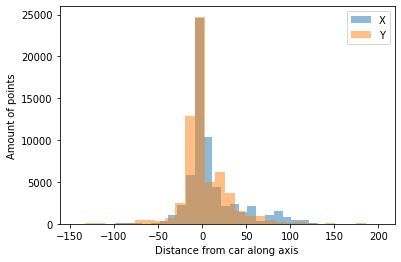

In [9]:
sample_token = train_df.first_sample_token.values[0]
sample = level5data.get("sample", sample_token)

sample_lidar_token = sample["data"]["LIDAR_TOP"]
sample_rgb_token = sample["data"]["CAM_FRONT"]
lidar_data = level5data.get("sample_data", sample_lidar_token)
rgb_data = level5data.get("sample_data", sample_rgb_token)
lidar_filepath = level5data.get_sample_data_path(sample_lidar_token)
img_filepath = level5data.get_sample_data_path(sample_rgb_token)

ego_pose = level5data.get("ego_pose", lidar_data["ego_pose_token"])
calibrated_sensor_lidar = level5data.get("calibrated_sensor", lidar_data["calibrated_sensor_token"])
calibrated_sensor_rgb = level5data.get("calibrated_sensor", rgb_data["calibrated_sensor_token"])

#Homogeneous transformation matrix from car frame to world frame.
global_from_car = transform_matrix(ego_pose['translation'],
                                   Quaternion(ego_pose['rotation']), inverse=False)

#Homogeneous transformation matrix from sensor coordinate frame to ego car frame.
car_from_sensor_lidar = transform_matrix(calibrated_sensor_lidar['translation'], Quaternion(calibrated_sensor_lidar['rotation']),
                                    inverse=False)

lidar_pointcloud = LidarPointCloud.from_file(lidar_filepath)

#The lidar pointcloud is defined in the sensor's reference frame.
#It must be in the car's reference frame, so we transform each point
lidar_pointcloud.transform(car_from_sensor_lidar)

#A sanity check, the points should be centered around 0 in car space.
plt.hist(lidar_pointcloud.points[0], alpha=0.5, bins=30, label="X")
plt.hist(lidar_pointcloud.points[1], alpha=0.5, bins=30, label="Y")
plt.legend()
plt.xlabel("Distance from car along axis")
plt.ylabel("Amount of points")
plt.show()

In [10]:
map_mask = level5data.map[0]["mask"]

def get_semantic_map_around_ego(map_mask, ego_pose, voxel_size, output_shape):

    def crop_image(image: np.array,
                           x_px: int,
                           y_px: int,
                           axes_limit_px: int) -> np.array:
                x_min = int(x_px - axes_limit_px)
                x_max = int(x_px + axes_limit_px)
                y_min = int(y_px - axes_limit_px)
                y_max = int(y_px + axes_limit_px)

                cropped_image = image[y_min:y_max, x_min:x_max]

                return cropped_image

    pixel_coords = map_mask.to_pixel_coords(ego_pose['translation'][0], ego_pose['translation'][1])

    extent = voxel_size*output_shape[0]*0.5
    scaled_limit_px = int(extent * (1.0 / (map_mask.resolution)))
    mask_raster = map_mask.mask()

    cropped = crop_image(mask_raster, pixel_coords[0], pixel_coords[1], int(scaled_limit_px * np.sqrt(2)))

    ypr_rad = Quaternion(ego_pose['rotation']).yaw_pitch_roll
    yaw_deg = -np.degrees(ypr_rad[0])

    rotated_cropped = np.array(Image.fromarray(cropped).rotate(yaw_deg))
    ego_centric_map = crop_image(rotated_cropped, rotated_cropped.shape[1] / 2, rotated_cropped.shape[0] / 2,
                                 scaled_limit_px)[::-1]
    
    ego_centric_map = cv2.resize(ego_centric_map, output_shape[:2], cv2.INTER_NEAREST)
    return ego_centric_map.astype(np.float32)/255

def create_transformation_matrix_to_voxel_space(shape, voxel_size, offset):
    """
    Constructs a transformation matrix given an output voxel shape such that (0,0,0) ends up in the center.
    Voxel_size defines how large every voxel is in world coordinate, (1,1,1) would be the same as Minecraft voxels.
    
    An offset per axis in world coordinates (metric) can be provided, this is useful for Z (up-down) in lidar points.
    """
    
    shape, voxel_size, offset = np.array(shape), np.array(voxel_size), np.array(offset)
    
    tm = np.eye(4, dtype=np.float32)
    translation = shape/2 + offset/voxel_size
    
    tm = tm * np.array(np.hstack((1/voxel_size, [1])))

    tm[:3, 3] = np.transpose(translation)
    return tm

def transform_points(points, transf_matrix):
    """
    Transform (3,N) or (4,N) points using transformation matrix.
    """
    if points.shape[0] not in [3,4]:
        raise Exception("Points input should be (3,N) or (4,N) shape, received {}".format(points.shape))
    return transf_matrix.dot(np.vstack((points[:3, :], np.ones(points.shape[1]))))[:3, :]

def car_to_voxel_coords(points, shape, voxel_size, z_offset=0):
    if len(shape) != 3:
        raise Exception("Voxel volume shape should be 3 dimensions (x,y,z)")
        
    if len(points.shape) != 2 or points.shape[0] not in [3, 4]:
        raise Exception("Input points should be (3,N) or (4,N) in shape, found {}".format(points.shape))

    tm = create_transformation_matrix_to_voxel_space(shape, voxel_size, (0, 0, z_offset))
    p = transform_points(points, tm)
    return p

def create_voxel_pointcloud(points, shape, voxel_size=(0.5,0.5,1), z_offset=0):

    points_voxel_coords = car_to_voxel_coords(points.copy(), shape, voxel_size, z_offset)
    points_voxel_coords = points_voxel_coords[:3].transpose(1,0)
    points_voxel_coords = np.int0(points_voxel_coords)
    
    bev = np.zeros(shape, dtype=np.float32)
    bev_shape = np.array(shape)

    within_bounds = (np.all(points_voxel_coords >= 0, axis=1) * np.all(points_voxel_coords < bev_shape, axis=1))
    
    points_voxel_coords = points_voxel_coords[within_bounds]
    coord, count = np.unique(points_voxel_coords, axis=0, return_counts=True)
        
    # Note X and Y are flipped:
    bev[coord[:,1], coord[:,0], coord[:,2]] = count
    
    return bev

def normalize_voxel_intensities(bev, max_intensity=16):
    return (bev/max_intensity).clip(0,1)


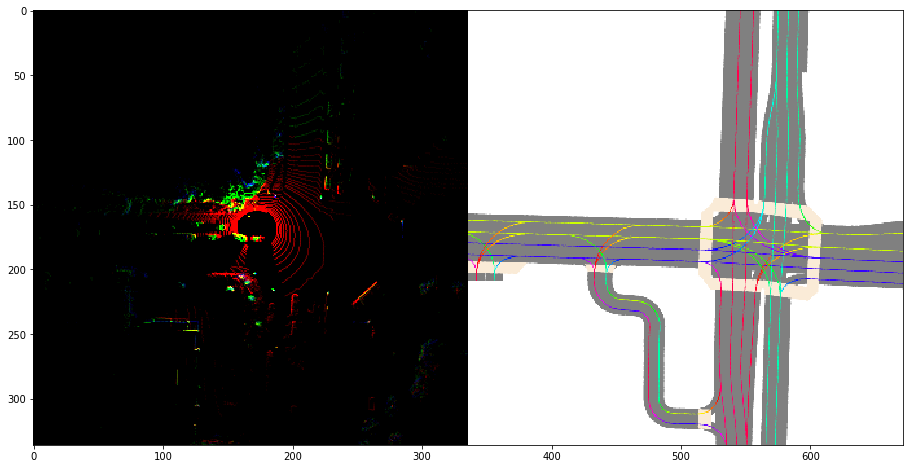

In [11]:
voxel_size = (0.4,0.4,1.5)
z_offset = -2.0
bev_shape = (336,336, 3)

bev = create_voxel_pointcloud(lidar_pointcloud.points, bev_shape, voxel_size=voxel_size, z_offset=z_offset)

ego_centric_map = get_semantic_map_around_ego(map_mask, ego_pose, voxel_size=0.4, output_shape=(336,336)) 
# So that the values in the voxels range from 0,1 we set a maximum intensity.
bev = normalize_voxel_intensities(bev)

plt.figure(figsize=(16,8))
plt.imshow(np.hstack((bev, ego_centric_map)))
plt.show()

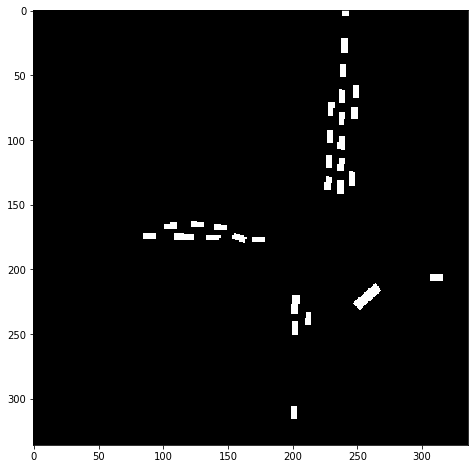

In [12]:
boxes = level5data.get_boxes(sample_lidar_token)
#print(boxes)
target_im = np.zeros(bev.shape[:3], dtype=np.uint8)

def move_boxes_to_car_space(boxes, ego_pose):
    """
    Move boxes from world space to car space.
    Note: mutates input boxes.
    """
    translation = -np.array(ego_pose['translation'])
    rotation = Quaternion(ego_pose['rotation']).inverse
    
    for box in boxes:
        # Bring box to car space
        box.translate(translation)
        box.rotate(rotation)
        
def scale_boxes(boxes, factor):
    """
    Note: mutates input boxes
    """
    for box in boxes:
        box.wlh = box.wlh * factor

def draw_boxes(im, voxel_size, boxes, classes, z_offset=0.0):
    for box in boxes:
        # We only care about the bottom corners
        corners = box.bottom_corners()
        corners_voxel = car_to_voxel_coords(corners, im.shape, voxel_size, z_offset).transpose(1,0)
        corners_voxel = corners_voxel[:,:2] # Drop z coord

        class_color = classes.index(box.name) + 1
        
        if class_color == 0:
            raise Exception("Unknown class: {}".format(box.name))

        cv2.drawContours(im, np.int0([corners_voxel]), 0, (class_color, class_color, class_color), -1)

move_boxes_to_car_space(boxes, ego_pose)
scale_boxes(boxes, 0.8)
draw_boxes(target_im, voxel_size, boxes, classes, z_offset=z_offset)
#target_im = target_im[:,:,0] # take one channel only

plt.figure(figsize=(8,8))
plt.imshow((target_im > 0).astype(np.float32), cmap='Set2')
plt.show()


In [13]:
# Some hyperparameters we'll need to define for the system
voxel_size = (0.4, 0.4, 1.5)
z_offset = -2.0
bev_shape = (336,336, 3)

# We scale down each box so they are more separated when projected into our coarse voxel space.
box_scale = 0.8

# "bev" stands for birds eye view
train_data_folder = os.path.join(ARTIFACTS_FOLDER, "bev_train_data")
validation_data_folder = os.path.join(ARTIFACTS_FOLDER, "./bev_validation_data")

NUM_WORKERS = os.cpu_count()

def prepare_training_data_for_scene(first_sample_token, output_folder, bev_shape, voxel_size, z_offset, box_scale, level5data):
    """
    Given a first sample token (in a scene), output rasterized input volumes and targets in birds-eye-view perspective.
    

    """
    sample_token = first_sample_token
    
    while sample_token:
        
        sample = level5data.get("sample", sample_token)

        sample_lidar_token = sample["data"]["LIDAR_TOP"]
        lidar_data = level5data.get("sample_data", sample_lidar_token)
        lidar_filepath = level5data.get_sample_data_path(sample_lidar_token)

        ego_pose = level5data.get("ego_pose", lidar_data["ego_pose_token"])
        calibrated_sensor = level5data.get("calibrated_sensor", lidar_data["calibrated_sensor_token"])


        global_from_car = transform_matrix(ego_pose['translation'],
                                           Quaternion(ego_pose['rotation']), inverse=False)

        car_from_sensor = transform_matrix(calibrated_sensor['translation'], Quaternion(calibrated_sensor['rotation']),
                                            inverse=False)

        try:
            lidar_pointcloud = LidarPointCloud.from_file(lidar_filepath)
            lidar_pointcloud.transform(car_from_sensor)
        except Exception as e:
            print ("Failed to load Lidar Pointcloud for {}: {}:".format(sample_token, e))
            sample_token = sample["next"]
            continue
        
        bev = create_voxel_pointcloud(lidar_pointcloud.points, bev_shape, voxel_size=voxel_size, z_offset=z_offset)
        bev = normalize_voxel_intensities(bev)

        
        boxes = level5data.get_boxes(sample_lidar_token)

        target = np.zeros(bev.shape[:3], dtype=np.uint8)
        classes = ["car", "motorcycle", "bus", "bicycle", "truck", "pedestrian", "other_vehicle", "animal", "emergency_vehicle"]
        move_boxes_to_car_space(boxes, ego_pose)
        scale_boxes(boxes, box_scale)
        draw_boxes(target, voxel_size, boxes=boxes, classes=classes, z_offset=z_offset)

        bev_im = np.round(bev*255).astype(np.uint8)
        target_im = target[:,:,0] # take one channel only
        
        semantic_im = get_semantic_map_around_ego(map_mask, ego_pose, voxel_size[0], target_im.shape)
        semantic_im = np.round(semantic_im*255).astype(np.uint8)
        
        #bev projection withou boxes
        cv2.imwrite(os.path.join(output_folder, "{}_input.png".format(sample_token)), bev_im)
        #mage with the boxes
        cv2.imwrite(os.path.join(output_folder, "{}_target.png".format(sample_token)), target)
        #semantic map of the scene, to be used for visualization after training
        cv2.imwrite(os.path.join(output_folder, "{}_map.png".format(sample_token)), semantic_im)
        
        sample_token = sample["next"]

# NOTE: Need to do the following cell just once! uncomment for Linux or Mac, issues in Windows due to multiprocessing library of Anaconda

In [14]:
# for df, data_folder in [(train_df, train_data_folder), (validation_df, validation_data_folder)]:
#     print("Preparing data into {} using {} workers".format(data_folder, NUM_WORKERS))
#     first_samples = df.first_sample_token.values
#     os.makedirs(data_folder, exist_ok=True)
#     process_func = partial(prepare_training_data_for_scene,
#                            output_folder=data_folder, bev_shape=bev_shape, voxel_size=voxel_size, z_offset=z_offset, box_scale=box_scale, level5data=level5data)

#     print(len(first_samples))

# #     pool = Pool(NUM_WORKERS)
# #     for _ in tqdm_notebook(process_func(first_samples), total=len(first_samples)):
# #         pass
# #     pool.close()

#     for i in range(len(first_samples)):
#         process_func(first_samples[i])

In [15]:
# first_samples = df.first_sample_token.values

# prepare_training_data_for_scene(first_samples[18], output_folder=train_data_folder, bev_shape=bev_shape, voxel_size=voxel_size, z_offset=z_offset, box_scale=box_scale, level5data=level5data)

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data

class BEVImageDataset(torch.utils.data.Dataset):
    """
    
    Takes as input the filepaths, and outputs the tensors corresponding to the bev, the target with the bounding boxes
    and the semantic map of the sourrounding area.
    
    """
    def __init__(self, input_filepaths, target_filepaths, map_filepaths=None):
        self.input_filepaths = input_filepaths
        self.target_filepaths = target_filepaths
        self.map_filepaths = map_filepaths
        
        if map_filepaths is not None:
            assert len(input_filepaths) == len(map_filepaths)
        
        assert len(input_filepaths) == len(target_filepaths)

    def __len__(self):
        return len(self.input_filepaths)

    def __getitem__(self, idx):
        input_filepath = self.input_filepaths[idx]
        target_filepath = self.target_filepaths[idx]
        
        sample_token = input_filepath.split("/")[-1].replace("_input.png","")
        
        im = cv2.imread(input_filepath, cv2.IMREAD_COLOR)
        
        if self.map_filepaths:
            map_filepath = self.map_filepaths[idx]
            map_im = cv2.imread(map_filepath, cv2.IMREAD_UNCHANGED)
            im = np.concatenate((im, map_im), axis=2)
        
        target = cv2.imread(target_filepath, cv2.IMREAD_COLOR)
        
        im = im.astype(np.float32)/255
        target = target.astype(np.int64)
        
        im = tf.convert_to_tensor(im.transpose(2,0,1))
        target = tf.convert_to_tensor(target)
        
        return im, target, sample_token

input_filepaths = sorted(glob.glob(os.path.join(train_data_folder, "*_input.png")))
target_filepaths = sorted(glob.glob(os.path.join(train_data_folder, "*_target.png")))
map_filepaths = sorted(glob.glob(os.path.join(train_data_folder, "*_map.png")))

train_dataset = BEVImageDataset(input_filepaths, target_filepaths, map_filepaths)
print(len(train_dataset))
im, targets, sample_tokens = train_dataset[1]



13594


## <font color="pink">TRAINING</font>
Based on the [AVOD algorithm](https://github.com/kujason/avod), we train the dataset. 
The goal is to study how the accuracy changes based on the type of sensors in input, and their number, thus changes to the AVOD algorithm have been made. Here we keep the two stage model.
Will be divided in steps, to mimick the divisions made by AVOD's authors in the code.

With respect to the original AVOD code, the following changes have been made:
<li> Upgrades for compatibity issues with tensorflow 2.0: migrated from slim libs to keras Sequential</li>
<li> Changes to support single type input </li>
<li> VGGs take as input Lyft-style dataset </li>



In [17]:
import avod
#from avod.builders.dataset_builder import DatasetBuilder
#from avod.core.models.avod_model import AvodModel
#from avod.core.models.rpn_model import RpnModel
from avod.core import trainer

<b>RPN MODEL</b>: It is the fist subnetwork that makes up the double stage AVOD algorithm. It uses two VGGs, one for images, one for LiDar, to find the bottleneck.
Img VGG and Bev VGG have the same strucure, just have input from different sources. 

<b>VGG:</b> VGG is a convolutional neural network model. Here simplified model wrt K. Simonyan and A. Zisserman's model proposed in the paper "Very Deep Convolutional Networks for Large-Scale Image Recognition".
Basically, it lacks dense layers at the end, and the last group of conv layers is smaller that theirs.
Two VGGs, one for BEV, one for Images

<b> helper functions:</b> [todo] fucking move them to separate classes, but just keep the stuff that you used, not like avod

In [18]:
import numpy as np
import tensorflow as tf

import avod.core.format_checker as fc
from avod.core.minibatch_samplers import balanced_positive_negative_sampler
def sample_mini_batch(max_ious,
                          mini_batch_size,
                          negative_iou_range,
                          positive_iou_range):
        """
        Samples a mini batch based on anchor ious with ground truth

        Args:
            max_ious: a tensor of max ious with ground truth in
                the shape (N,)
            mini_batch_size: size of the mini batch to return
            negative_iou_range: iou range to consider an anchor as negative
            positive_iou_range: iou range to consider an anchor as positive

        Returns:
            mb_sampled: a boolean mask where True indicates anchors sampled
                for the mini batch
            mb_pos_sampled: a boolean mask where True indicates positive anchors
        """

        bkg_and_neg_labels = tf.less(max_ious, negative_iou_range[1])
        pos_labels = tf.greater(max_ious, positive_iou_range[0])
        indicator = tf.logical_or(pos_labels, bkg_and_neg_labels)

        if negative_iou_range[0] > 0.0:
            # If neg_iou_lo is > 0.0, the mini batch may be empty.
            # In that case, use all background and negative labels
            neg_labels = tf.logical_and(bkg_and_neg_labels, tf.greater_equal(max_ious, negative_iou_range[0]))

            new_indicator = tf.logical_or(pos_labels, neg_labels)

            num_valid = tf.reduce_sum(tf.cast(indicator, tf.int32))
            indicator = tf.cond(tf.greater(num_valid, 0), true_fn=lambda: tf.identity(new_indicator), 
                                false_fn=lambda: tf.identity(bkg_and_neg_labels))

        sampler = balanced_positive_negative_sampler.BalancedPositiveNegativeSampler()
        mb_sampled, mb_pos_sampled = sampler.subsample( indicator, mini_batch_size, pos_labels)

        return mb_sampled, mb_pos_sampled
    
def anchor_to_offset(anchors, ground_truth):
    """Encodes the anchor regression predictions with the
    ground truth.

    Args:
        anchors: A numpy array of shape (N, 6) representing
            the generated anchors.
        ground_truth: A numpy array of shape (6,) containing
            the label boxes in the anchor format.

    Returns:
        anchor_offsets: A numpy array of shape (N, 6)
            encoded/normalized with the ground-truth, representing the
            offsets.
    """

    fc.check_anchor_format(anchors)

    anchors = np.asarray(anchors).reshape(-1, 6)
    ground_truth = np.reshape(ground_truth, (6,))

    # t_x_gt = (x_gt - x_anch)/dim_x_anch
    t_x_gt = (ground_truth[0] - anchors[:, 0]) / anchors[:, 3]
    # t_y_gt = (y_gt - y_anch)/dim_y_anch
    t_y_gt = (ground_truth[1] - anchors[:, 1]) / anchors[:, 4]
    # t_z_gt = (z_gt - z_anch)/dim_z_anch
    t_z_gt = (ground_truth[2] - anchors[:, 2]) / anchors[:, 5]
    # t_dx_gt = log(dim_x_gt/dim_x_anch)
    t_dx_gt = np.log(ground_truth[3] / anchors[:, 3])
    # t_dy_gt = log(dim_y_gt/dim_y_anch)
    t_dy_gt = np.log(ground_truth[4] / anchors[:, 4])
    # t_dz_gt = log(dim_z_gt/dim_z_anch)
    t_dz_gt = np.log(ground_truth[5] / anchors[:, 5])
    anchor_offsets = np.stack((t_x_gt, t_y_gt, t_z_gt, t_dx_gt, t_dy_gt, t_dz_gt), axis=1)
    return anchor_offsets


def tf_anchor_to_offset(anchors, ground_truth):
    """Encodes the anchor regression predictions with the
    ground truth.

    This function assumes the ground_truth tensor has been arranged
    in a way that each corresponding row in ground_truth, is matched
    with that anchor according to the highest IoU.
    For instance, the ground_truth might be a matrix of shape (256, 6)
    of repeated entries for the original ground truth of shape (x, 6),
    where each entry has been selected as the highest IoU match with that
    anchor. This is different from the same function in numpy format, where
    we loop through all the ground truth anchors, and calculate IoUs for
    each and then select the match with the highest IoU.

    Args:
        anchors: A tensor of shape (N, 6) representing
            the generated anchors.
        ground_truth: A tensor of shape (N, 6) containing
            the label boxes in the anchor format. Each ground-truth entry
            has been matched with the anchor in the same entry as having
            the highest IoU.

    Returns:
        anchor_offsets: A tensor of shape (N, 6)
            encoded/normalized with the ground-truth, representing the
            offsets.
    """

    fc.check_anchor_format(anchors)

    # Make sure anchors and anchor_gts have the same shape
    dim_cond = tf.equal(tf.shape(anchors), tf.shape(ground_truth))

    with tf.control_dependencies([dim_cond]):
        t_x_gt = (ground_truth[:, 0] - anchors[:, 0]) / anchors[:, 3]
        t_y_gt = (ground_truth[:, 1] - anchors[:, 1]) / anchors[:, 4]
        t_z_gt = (ground_truth[:, 2] - anchors[:, 2]) / anchors[:, 5]
        t_dx_gt = tf.math.log(ground_truth[:, 3] / anchors[:, 3])
        t_dy_gt = tf.math.log(ground_truth[:, 4] / anchors[:, 4])
        t_dz_gt = tf.math.log(ground_truth[:, 5] / anchors[:, 5])
        anchor_offsets = tf.stack((t_x_gt,
                                   t_y_gt,
                                   t_z_gt,
                                   t_dx_gt,
                                   t_dy_gt,
                                   t_dz_gt), axis=1)

        return anchor_offsets


def offset_to_anchor(anchors, offsets):
    """Decodes the anchor regression predictions with the
    anchor.

    Args:
        anchors: A numpy array or a tensor of shape [N, 6]
            representing the generated anchors.
        offsets: A numpy array or a tensor of shape
            [N, 6] containing the predicted offsets in the
            anchor format  [x, y, z, dim_x, dim_y, dim_z].

    Returns:
        anchors: A numpy array of shape [N, 6]
            representing the predicted anchor boxes.
    """

    fc.check_anchor_format(anchors)
    fc.check_anchor_format(offsets)

    # x = dx * dim_x + x_anch
    x_pred = (offsets[:, 0] * anchors[:, 3]) + anchors[:, 0]
    # y = dy * dim_y + x_anch
    y_pred = (offsets[:, 1] * anchors[:, 4]) + anchors[:, 1]
    # z = dz * dim_z + z_anch
    z_pred = (offsets[:, 2] * anchors[:, 5]) + anchors[:, 2]

    tensor_format = isinstance(anchors, tf.Tensor)
    if tensor_format:
        # dim_x = exp(log(dim_x) + dx)
        dx_pred = tf.math.exp(tf.math.log(anchors[:, 3]) + offsets[:, 3])
        # dim_y = exp(log(dim_y) + dy)
        dy_pred = tf.math.exp(tf.math.log(anchors[:, 4]) + offsets[:, 4])
        # dim_z = exp(log(dim_z) + dz)
        dz_pred = tf.math.exp(tf.math.log(anchors[:, 5]) + offsets[:, 5])
        anchors = tf.stack((x_pred,
                            y_pred,
                            z_pred,
                            dx_pred,
                            dy_pred,
                            dz_pred), axis=1)
    else:
        dx_pred = np.exp(np.log(anchors[:, 3]) + offsets[:, 3])
        dy_pred = np.exp(np.log(anchors[:, 4]) + offsets[:, 4])
        dz_pred = np.exp(np.log(anchors[:, 5]) + offsets[:, 5])
        anchors = np.stack((x_pred,
                            y_pred,
                            z_pred,
                            dx_pred,
                            dy_pred,
                            dz_pred), axis=1)

    return anchors


In [ ]:
import csv
import numpy as np
import cv2
import os


class FrameCalibrationData:
    """Frame Calibration Holder
        3x3    intrinsic   Intrinsic camera matrix.

        3x3    rotation    Rotation matrix.
        
        3x1    translation Translation vector

        """

    def __init__(self):
        self.intrinsic = []
        self.rotation = []
        self.translation = []

def read_calibration(sensor_token):
    """Reads in Calibration file from Kitti Dataset.

    Keyword Arguments:
    ------------------
    sensor_token: keyword argument of the sensor that captured the frame.

    Returns:
    --------
    frame_calibration_info : frame full calibration info

    """
    
    calib_sensor_data = level5data.get("calibrated_sensor", token)
    intrinsic_temp = calib_sensor_data.get("camera_intrinsic")
    rotation_temp = calib_sensor_data.get("rotation")
    translation_temp = calib_sensor_data.get("translation")
    
    frame_calibration_info=FrameCalibrationData()
    frame_calibration_info.intrinsic=intrinsic_temp
    frame_calibration_info.rotation=rotation_temp
    frame_calibration_info.translation=translation_temp
    
    return frame_calibration_info
    

In [23]:
#from avod.builders import feature_extractor_builder
#from avod_lyft.avod.core.feature_extractors import BevVgg
#from avod.core.feature_extractors import ImgVgg
#from avod.core import anchor_encoder
from PIL import Image
from avod.core import anchor_filter
from avod.core import anchor_projector
from avod.core import box_3d_encoder
from avod.core import constants
from avod.core import losses
from avod.core import model
from avod.core import summary_utils
from avod.core.anchor_generators import grid_anchor_3d_generator
from avod.datasets.kitti import kitti_aug

tf.compat.v1.disable_eager_execution()
class RpnModel(model.DetectionModel):
    ##############################
    # Keys for Placeholders
    ##############################
    PL_BEV_INPUT = 'bev_input_pl'
    PL_IMG_INPUT = 'img_input_pl'
    PL_ANCHORS = 'anchors_pl'

    PL_BEV_ANCHORS = 'bev_anchors_pl'
    PL_BEV_ANCHORS_NORM = 'bev_anchors_norm_pl'
    PL_IMG_ANCHORS = 'img_anchors_pl'
    PL_IMG_ANCHORS_NORM = 'img_anchors_norm_pl'
    #PL_LABEL_ANCHORS = 'label_anchors_pl'
    PL_LABEL_BOXES_3D = 'label_boxes_3d_pl'
    PL_LABEL_CLASSES = 'label_classes_pl'

    PL_ANCHOR_IOUS = 'anchor_ious_pl'
    PL_ANCHOR_OFFSETS = 'anchor_offsets_pl'
    PL_ANCHOR_CLASSES = 'anchor_classes_pl'

    # Sample info, including keys for projection to image space
    # (e.g. camera matrix, image index, etc.)
    PL_CALIB_P2 = 'frame_calib_p2'
    PL_IMG_IDX = 'current_img_idx'
    PL_GROUND_PLANE = 'ground_plane'

    ##############################
    # Keys for Predictions
    ##############################
    PRED_ANCHORS = 'rpn_anchors'

    PRED_MB_OBJECTNESS_GT = 'rpn_mb_objectness_gt'
    PRED_MB_OFFSETS_GT = 'rpn_mb_offsets_gt'

    PRED_MB_MASK = 'rpn_mb_mask'
    PRED_MB_OBJECTNESS = 'rpn_mb_objectness'
    PRED_MB_OFFSETS = 'rpn_mb_offsets'

    PRED_TOP_INDICES = 'rpn_top_indices'
    PRED_TOP_ANCHORS = 'rpn_top_anchors'
    PRED_TOP_OBJECTNESS_SOFTMAX = 'rpn_top_objectness_softmax'

    ##############################
    # Keys for Loss
    ##############################
    LOSS_RPN_OBJECTNESS = 'rpn_objectness_loss'
    LOSS_RPN_REGRESSION = 'rpn_regression_loss'

    def __init__(self, model_config, pipeline_config, train_val_test, dataset):
        """
        Args:
            model_config: configuration for the model
            train_val_test: "train", "val", or "test"
            dataset: the dataset that will provide samples and ground truth
        """

        # Sets model configs (_config)
        super(RpnModel, self).__init__(model_config)
        self.pipeline_config = pipeline_config

        if train_val_test not in ["train", "val", "test"]:
            raise ValueError('Invalid train_val_test value,'
                             'should be one of ["train", "val", "test"]')
        self._train_val_test = train_val_test

        self._is_training = (self._train_val_test == 'train')

        # Input config
        input_config = self._config.input_config
        self._bev_pixel_size = np.asarray([input_config.bev_dims_h,
                                           input_config.bev_dims_w])
        self._bev_depth = input_config.bev_depth

        self._img_pixel_size = np.asarray([input_config.img_dims_h,
                                           input_config.img_dims_w])
        self._img_depth = input_config.img_depth

        # Rpn config
        rpn_config = self._config.rpn_config
        self.proposal_roi_crop_size = 3*2  #3*2
        self._fusion_method = rpn_config.rpn_fusion_method

        if self._train_val_test in ["train", "val"]:
            self._nms_size = rpn_config.rpn_train_nms_size
        else:
            self._nms_size = rpn_config.rpn_test_nms_size

        self._nms_iou_thresh = rpn_config.rpn_nms_iou_thresh

        # Network input placeholders
        self.placeholders = dict()

        # Inputs to network placeholders
        self._placeholder_inputs = dict()

        # Information about the current sample
        self.sample_info = dict()

        # Dataset
        self.dataset = dataset
        self.dataset.train_val_test = self._train_val_test
        area_extents = self.pipeline_config.kitti_utils_config.area_extents
        self._area_extents = np.reshape(area_extents, (3, 2))
        self._bev_extents = self._area_extents[[0, 2]]
        #self._cluster_sizes, _ = self.dataset.get_cluster_info() 
        anchor_strides = self.pipeline_config.kitti_utils_config.anchor_strides
        self._anchor_strides= np.reshape(anchor_strides, (-1, 2))
        self._anchor_generator = grid_anchor_3d_generator.GridAnchor3dGenerator()

        self._path_drop_probabilities = self._config.path_drop_probabilities
        self._train_on_all_samples = self._config.train_on_all_samples
        self._eval_all_samples = self._config.eval_all_samples

        if self._train_val_test in ["val", "test"]:
            # Disable path-drop, this should already be disabled inside the
            # evaluator, but just in case.
            self._path_drop_probabilities[0] = 1.0
            self._path_drop_probabilities[1] = 1.0

    def _add_placeholder(self, dtype, shape, name):
        placeholder = tf.compat.v1.placeholder(dtype, shape, name)
        self.placeholders[name] = placeholder
        return placeholder

    def _set_up_input_pls(self):
        """Sets up input placeholders by adding them to self._placeholders.
        Keys are defined as self.PL_*.
        """
        # Combine config data
        bev_dims = np.append(self._bev_pixel_size, self._bev_depth)

        with tf.compat.v1.variable_scope('bev_input'):
            # Placeholder for BEV image input, to be filled in with feed_dict
            bev_input_placeholder = self._add_placeholder(tf.float32, bev_dims,
                                                          self.PL_BEV_INPUT)

            self._bev_input_batches = tf.expand_dims(
                bev_input_placeholder, axis=0)

            self._bev_preprocessed = tf.image.resize(self._bev_input_batches, self._bev_pixel_size)

            # Summary Images
            bev_summary_images = tf.split(
                bev_input_placeholder, self._bev_depth, axis=2)
            tf.summary.image("bev_maps", bev_summary_images,
                             max_outputs=self._bev_depth)

        with tf.compat.v1.variable_scope('img_input'):
            # Take variable size input images
            img_input_placeholder = self._add_placeholder(
                tf.float32,
                [None, None, self._img_depth],
                self.PL_IMG_INPUT)

            self._img_input_batches = tf.expand_dims(
                img_input_placeholder, axis=0)

            self._img_preprocessed = tf.image.resize(self._img_input_batches, self._img_pixel_size)

            # Summary Image
            tf.summary.image("rgb_image", self._img_preprocessed,
                             max_outputs=2)

        with tf.compat.v1.variable_scope('pl_labels'):
            #self._add_placeholder(tf.float32, [None, 6], self.PL_LABEL_ANCHORS)
            self._add_placeholder(tf.float32, [None, 7], self.PL_LABEL_BOXES_3D)
            self._add_placeholder(tf.float32, [None], self.PL_LABEL_CLASSES)

        # Placeholders for anchors
        with tf.compat.v1.variable_scope('pl_anchors'):
            self._add_placeholder(tf.float32, [None, 6], self.PL_ANCHORS)
            self._add_placeholder(tf.float32, [None], self.PL_ANCHOR_IOUS)
            self._add_placeholder(tf.float32, [None, 6], self.PL_ANCHOR_OFFSETS)
            self._add_placeholder(tf.float32, [None], self.PL_ANCHOR_CLASSES)

            with tf.compat.v1.variable_scope('bev_anchor_projections'):
                self._add_placeholder(tf.float32, [None, 4], self.PL_BEV_ANCHORS)
                self._bev_anchors_norm_pl = self._add_placeholder( tf.float32, [None, 4], self.PL_BEV_ANCHORS_NORM)

            with tf.compat.v1.variable_scope('img_anchor_projections'):
                self._add_placeholder(tf.float32, [None, 4], self.PL_IMG_ANCHORS)
                self._img_anchors_norm_pl = self._add_placeholder( tf.float32, [None, 4], self.PL_IMG_ANCHORS_NORM)

            with tf.compat.v1.variable_scope('sample_info'):
                # the calib matrix shape is (3 x 4)
                self._add_placeholder( tf.float32, [3, 4], self.PL_CALIB_P2)
                self._add_placeholder(tf.int32, shape=[1], name=self.PL_IMG_IDX)
                self._add_placeholder(tf.float32, [4], self.PL_GROUND_PLANE)

    def _set_up_feature_extractors(self):
        """Sets up feature extractors and stores feature maps and
        bottlenecks as member variables.
        """
        weight_decay=0.0005
        #shape due to shape provided by dataset. BEV could not be adapted: too sparse.
        
        inputs_img = tf.keras.layers.Input(batch_shape=(None,1024,1224,3))
        net = tf.keras.layers.Conv2D(filters = 32, kernel_size = [3,3], strides =(1,1), bias_initializer=tf.zeros_initializer(), 
                                     activation=tf.nn.relu, kernel_initializer='ones', kernel_regularizer=tf.keras.regularizers.l2(weight_decay),
                                     use_bias=False, padding='same', name="conv1")(inputs_img)
        net = tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones',
                                        moving_mean_initializer='zeros', moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None,
                                        beta_constraint=None, gamma_constraint=None, name="batch1")(net)
        net = tf.keras.layers.Conv2D(filters = 32, kernel_size = [3,3], strides =(1,1), bias_initializer=tf.zeros_initializer(), activation=tf.nn.relu,
                                     kernel_initializer='ones', kernel_regularizer=tf.keras.regularizers.l2(weight_decay), 
                                     use_bias=False, padding='same', name="conv2")(net)
        net = tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones',
                                        moving_mean_initializer='zeros', moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None,
                                        beta_constraint=None, gamma_constraint=None, name="batch2")(net)   

        net = tf.keras.layers.MaxPooling2D(pool_size=[2,2], strides=None, padding="valid", name="pool1")(net)

        net = tf.keras.layers.Conv2D(filters = 64, kernel_size = [3,3], strides =(1,1), bias_initializer=tf.zeros_initializer(), activation=tf.nn.relu,
                                     kernel_initializer='ones', kernel_regularizer=tf.keras.regularizers.l2(weight_decay),
                                     use_bias=False, padding='same', name="conv3")(net)
        net = tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones',
                                        moving_mean_initializer='zeros', moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None,
                                        beta_constraint=None, gamma_constraint=None, name="batch3")(net)
        net = tf.keras.layers.Conv2D(filters = 64, kernel_size = [3,3], strides =(1,1), bias_initializer=tf.zeros_initializer(), activation=tf.nn.relu,
                                     kernel_initializer='ones', kernel_regularizer=tf.keras.regularizers.l2(weight_decay),
                                     use_bias=False, padding='same', name="conv4")(net)
        net = tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones',
                                        moving_mean_initializer='zeros', moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None,
                                        beta_constraint=None, gamma_constraint=None, name="batch4")(net)

        net = tf.keras.layers.MaxPooling2D(pool_size=[2,2], strides=None, padding="valid", name="pool2")(net)

        net = tf.keras.layers.Conv2D(filters = 128,kernel_size = [3,3], strides =(1,1), bias_initializer=tf.zeros_initializer(), activation=tf.nn.relu,
                                     kernel_initializer='ones', kernel_regularizer=tf.keras.regularizers.l2(weight_decay),
                                     use_bias=False, padding='same', name="conv5")(net)
        net = tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones',
                                        moving_mean_initializer='zeros', moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None,
                                        beta_constraint=None, gamma_constraint=None, name="batch5")(net)
        net = tf.keras.layers.Conv2D(filters = 128, kernel_size = [3,3], strides =(1,1), bias_initializer=tf.zeros_initializer(), activation=tf.nn.relu,
                                     kernel_initializer='ones', kernel_regularizer=tf.keras.regularizers.l2(weight_decay), 
                                     use_bias=False, padding='same', name="conv6")(net)
        net = tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones',
                                        moving_mean_initializer='zeros', moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None,
                                        beta_constraint=None, gamma_constraint=None, name="batch6")(net)
        net = tf.keras.layers.Conv2D(filters = 128, kernel_size = [3,3], strides =(1,1), bias_initializer=tf.zeros_initializer(), activation=tf.nn.relu,
                                     kernel_initializer='ones', kernel_regularizer=tf.keras.regularizers.l2(weight_decay),
                                     use_bias=False, padding='same', name="conv7")(net)
        net = tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones',
                                        moving_mean_initializer='zeros', moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None,
                                        beta_constraint=None, gamma_constraint=None, name="batch7")(net)

        net = tf.keras.layers.MaxPooling2D(pool_size=[2,2], strides=None, padding="valid", name="pool3")(net)

        net = tf.keras.layers.Conv2D(filters = 256, kernel_size = [3,3], strides =(1,1), bias_initializer=tf.zeros_initializer(), activation=tf.nn.relu,
                                     kernel_initializer='ones', kernel_regularizer=tf.keras.regularizers.l2(weight_decay),
                                     use_bias=False, padding='same', name="conv8") (net)
        net = tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones',
                                        moving_mean_initializer='zeros', moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None,
                                        beta_constraint=None, gamma_constraint=None, name="batch8")(net)
        net = tf.keras.layers.Conv2D(filters = 256, kernel_size = [3,3], strides =(1,1), bias_initializer=tf.zeros_initializer(), activation=tf.nn.relu,
                                     kernel_initializer='ones', kernel_regularizer=tf.keras.regularizers.l2(weight_decay),
                                     use_bias=False, padding='same', name="conv9")(net)
        net = tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones',
                                        moving_mean_initializer='zeros', moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None,
                                        beta_constraint=None, gamma_constraint=None, name="batch9")(net)
        net = tf.keras.layers.Conv2D(filters = 256, kernel_size = [3,3], strides =(1,1), bias_initializer=tf.zeros_initializer(), activation=tf.nn.relu,
                                     kernel_initializer='ones', kernel_regularizer=tf.keras.regularizers.l2(weight_decay),
                                     use_bias=False, padding='same', name="conv10")(net)
        net = tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones',
                                        moving_mean_initializer='zeros', moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None,
                                        beta_constraint=None, gamma_constraint=None, name="batch10")(net)
        
        img_vgg = tf.keras.models.Model(inputs = inputs_img, outputs = net, name="img_vgg")
        
        self.img_bottleneck = tf.keras.layers.Conv2D(filters = 32, kernel_size = [1,1], strides =(1,1), padding='same', name="bottleneck")(net)
        self.img_bottleneck= tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros',
                                            gamma_initializer='ones', moving_mean_initializer='zeros', moving_variance_initializer='ones', 
                                            beta_regularizer=None, gamma_regularizer=None, beta_constraint=None, gamma_constraint=None)(self.img_bottleneck)
        
         #shape due to shape provided by dataset. BEV could not be adapted: too sparse.
        
        inputs_bev = tf.keras.layers.Input(batch_shape=(None,336,336,3))
        out = tf.keras.layers.Conv2D(filters = 32, kernel_size = [3,3], strides =(1,1), bias_initializer=tf.zeros_initializer(), 
                                     activation=tf.nn.relu, kernel_initializer='ones', kernel_regularizer=tf.keras.regularizers.l2(weight_decay),
                                     use_bias=False, padding='same', name="conv1")(inputs_bev)
        out = tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones',
                                        moving_mean_initializer='zeros', moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None,
                                        beta_constraint=None, gamma_constraint=None, name="batch1")(out)
        out = tf.keras.layers.Conv2D(filters = 32, kernel_size = [3,3], strides =(1,1), bias_initializer=tf.zeros_initializer(), activation=tf.nn.relu,
                                     kernel_initializer='ones', kernel_regularizer=tf.keras.regularizers.l2(weight_decay), 
                                     use_bias=False, padding='same', name="conv2")(out)
        out = tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones',
                                        moving_mean_initializer='zeros', moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None,
                                        beta_constraint=None, gamma_constraint=None, name="batch2")(out)   

        out = tf.keras.layers.MaxPooling2D(pool_size=[2,2], strides=None, padding="valid", name="pool1")(out)

        out = tf.keras.layers.Conv2D(filters = 64, kernel_size = [3,3], strides =(1,1), bias_initializer=tf.zeros_initializer(), activation=tf.nn.relu,
                                     kernel_initializer='ones', kernel_regularizer=tf.keras.regularizers.l2(weight_decay),
                                     use_bias=False, padding='same', name="conv3")(out)
        out = tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones',
                                        moving_mean_initializer='zeros', moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None,
                                        beta_constraint=None, gamma_constraint=None, name="batch3")(out)
        out = tf.keras.layers.Conv2D(filters = 64, kernel_size = [3,3], strides =(1,1), bias_initializer=tf.zeros_initializer(), activation=tf.nn.relu,
                                     kernel_initializer='ones', kernel_regularizer=tf.keras.regularizers.l2(weight_decay),
                                     use_bias=False, padding='same', name="conv4")(out)
        out = tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones',
                                        moving_mean_initializer='zeros', moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None,
                                        beta_constraint=None, gamma_constraint=None, name="batch4")(out)

        out = tf.keras.layers.MaxPooling2D(pool_size=[2,2], strides=None, padding="valid", name="pool2")(out)

        out = tf.keras.layers.Conv2D(filters = 128,kernel_size = [3,3], strides =(1,1), bias_initializer=tf.zeros_initializer(), activation=tf.nn.relu,
                                     kernel_initializer='ones', kernel_regularizer=tf.keras.regularizers.l2(weight_decay),
                                     use_bias=False, padding='same', name="conv5")(out)
        out = tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones',
                                        moving_mean_initializer='zeros', moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None,
                                        beta_constraint=None, gamma_constraint=None, name="batch5")(out)
        out = tf.keras.layers.Conv2D(filters = 128, kernel_size = [3,3], strides =(1,1), bias_initializer=tf.zeros_initializer(), activation=tf.nn.relu,
                                     kernel_initializer='ones', kernel_regularizer=tf.keras.regularizers.l2(weight_decay), 
                                     use_bias=False, padding='same', name="conv6")(out)
        out = tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones',
                                        moving_mean_initializer='zeros', moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None,
                                        beta_constraint=None, gamma_constraint=None, name="batch6")(out)
        out = tf.keras.layers.Conv2D(filters = 128, kernel_size = [3,3], strides =(1,1), bias_initializer=tf.zeros_initializer(), activation=tf.nn.relu,
                                     kernel_initializer='ones', kernel_regularizer=tf.keras.regularizers.l2(weight_decay),
                                     use_bias=False, padding='same', name="conv7")(out)
        out = tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones',
                                        moving_mean_initializer='zeros', moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None,
                                        beta_constraint=None, gamma_constraint=None, name="batch7")(out)

        out = tf.keras.layers.MaxPooling2D(pool_size=[2,2], strides=None, padding="valid", name="pool3")(out)

        out = tf.keras.layers.Conv2D(filters = 256, kernel_size = [3,3], strides =(1,1), bias_initializer=tf.zeros_initializer(), activation=tf.nn.relu,
                                     kernel_initializer='ones', kernel_regularizer=tf.keras.regularizers.l2(weight_decay),
                                     use_bias=False, padding='same', name="conv8") (out)
        out = tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones',
                                        moving_mean_initializer='zeros', moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None,
                                        beta_constraint=None, gamma_constraint=None, name="batch8")(out)
        out = tf.keras.layers.Conv2D(filters = 256, kernel_size = [3,3], strides =(1,1), bias_initializer=tf.zeros_initializer(), activation=tf.nn.relu,
                                     kernel_initializer='ones', kernel_regularizer=tf.keras.regularizers.l2(weight_decay),
                                     use_bias=False, padding='same', name="conv9")(out)
        out = tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones',
                                        moving_mean_initializer='zeros', moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None,
                                        beta_constraint=None, gamma_constraint=None, name="batch9")(out)
        out = tf.keras.layers.Conv2D(filters = 256, kernel_size = [3,3], strides =(1,1), bias_initializer=tf.zeros_initializer(), activation=tf.nn.relu,
                                     kernel_initializer='ones', kernel_regularizer=tf.keras.regularizers.l2(weight_decay),
                                     use_bias=False, padding='same', name="conv10")(out)
        out = tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones',
                                        moving_mean_initializer='zeros', moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None,
                                        beta_constraint=None, gamma_constraint=None, name="batch10")(out)
        
        bev_vgg = tf.keras.models.Model(inputs = inputs_bev, outputs = out, name="bev_vgg")
        
        self.bev_bottleneck = tf.keras.layers.Conv2D(filters = 32, kernel_size = [1,1], strides =(1,1), padding='same', name="bottleneck")(out)
        self.bev_bottleneck= tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros',
                                            gamma_initializer='ones', moving_mean_initializer='zeros', moving_variance_initializer='ones', 
                                            beta_regularizer=None, gamma_regularizer=None, beta_constraint=None, gamma_constraint=None)(self.bev_bottleneck)

        # # Visualize the end point feature maps being used
        bev_vgg.summary()
        bev_end_point=bev_vgg.get_config()
        img_vgg.summary()
        img_end_point=img_vgg.get_config()

    def build(self):

        # Setup input placeholders
        self._set_up_input_pls()

        # Setup feature extractors
        self._set_up_feature_extractors()

        bev_proposal_input = self.bev_bottleneck
        img_proposal_input = self.img_bottleneck

        fusion_mean_div_factor = 2.0

        # If both img and bev probabilites are set to 1.0, don't do
        # path drop.
        if not (self._path_drop_probabilities[0] ==
                self._path_drop_probabilities[1] == 1.0):
            with tf.compat.v1.variable_scope('rpn_path_drop'):

                random_values = tf.random_uniform(shape=[3],
                                                  minval=0.0,
                                                  maxval=1.0)

                img_mask, bev_mask = self.create_path_drop_masks(
                    self._path_drop_probabilities[0],
                    self._path_drop_probabilities[1],
                    random_values)

                img_proposal_input = tf.multiply(img_proposal_input,
                                                 img_mask)

                bev_proposal_input = tf.multiply(bev_proposal_input,
                                                 bev_mask)

                self.img_path_drop_mask = img_mask
                self.bev_path_drop_mask = bev_mask

                # Overwrite the division factor
                fusion_mean_div_factor = img_mask + bev_mask

        with tf.compat.v1.variable_scope('proposal_roi_pooling'):

            with tf.compat.v1.variable_scope('box_indices'):
                def get_box_indices(boxes):
                    proposals_shape = boxes.get_shape().as_list()
                    if any(dim is None for dim in proposals_shape):
                        proposals_shape = tf.shape(boxes)
                    ones_mat = tf.ones(proposals_shape[:2], dtype=tf.int32)
                    multiplier = tf.expand_dims(
                        tf.range(start=0, limit=proposals_shape[0]), 1)
                    return tf.reshape(ones_mat * multiplier, [-1])

                bev_boxes_norm_batches = tf.expand_dims(
                    self._bev_anchors_norm_pl, axis=0)

                # These should be all 0's since there is only 1 image
                tf_box_indices = get_box_indices(bev_boxes_norm_batches)
            
            proposal_roi_size_tf = [3,3]
            # Do ROI Pooling on BEV
            bev_proposal_rois = tf.image.crop_and_resize(
                bev_proposal_input,
                self._bev_anchors_norm_pl,
                tf_box_indices,
                proposal_roi_size_tf)
            # Do ROI Pooling on image
            img_proposal_rois = tf.image.crop_and_resize(
                img_proposal_input,
                self._bev_anchors_norm_pl,
                tf_box_indices,
                proposal_roi_size_tf)

        with tf.compat.v1.variable_scope('proposal_roi_fusion'):
            rpn_fusion_out = None
            if self._fusion_method == 'mean':
                tf_features_sum = tf.add(bev_proposal_rois, img_proposal_rois)
                #rpn_fusion_out = tf.divide(tf_features_sum, fusion_mean_div_factor)
                rpn_fusion_out = tf.divide(tf_features_sum, 2)
            elif self._fusion_method == 'concat':
                rpn_fusion_out = tf.concat(
                    [bev_proposal_rois, img_proposal_rois], axis=3)
            else:
                raise ValueError('Invalid fusion method', self._fusion_method)

        with tf.compat.v1.variable_scope('anchor_predictor', 'ap', [rpn_fusion_out]):
            #None because unknown
            tensor_in = tf.keras.Input(shape=None, tensor=rpn_fusion_out)
            print("here", tf_features_sum)
            # Rpn layers config
            weight_decay = 0.005

            # Use conv2d instead of fully_connected layers.
            cls_fc6 = tf.keras.layers.Conv2D(filters=32, kernel_size = [3,3], kernel_initializer='ones', 
                                             kernel_regularizer=tf.keras.regularizers.l2(weight_decay), padding='VALID', name="conv1")(tensor_in)

            cls_fc6_drop = tf.keras.layers.Dropout(rate = 0.5, name="drop1")(cls_fc6)

            cls_fc7 = tf.keras.layers.Conv2D(filters=32, kernel_size = [1,1], kernel_initializer='ones',
                                             kernel_regularizer=tf.keras.regularizers.l2(weight_decay), padding='VALID', name="conv2")(cls_fc6_drop)

            cls_fc7_drop = tf.keras.layers.Dropout(rate = 0.5, name="drop2")(cls_fc7)

            cls_fc8 = tf.keras.layers.Conv2D(filters=2, kernel_size = [1,1], kernel_initializer='ones',
                                             kernel_regularizer=tf.keras.regularizers.l2(weight_decay), padding='VALID', name="conv3")(cls_fc7_drop)

            objectness = tf.squeeze(cls_fc8, axis=[1,2], name='conv3/squeezed')

            # Use conv2d instead of fully_connected layers.
            reg_fc6 = tf.keras.layers.Conv2D(filters=32, kernel_size = [3,3], kernel_initializer="ones", 
                                    kernel_regularizer=tf.keras.regularizers.l2(weight_decay), padding='VALID', name="conv4")(tensor_in)

            reg_fc6_drop = tf.keras.layers.Dropout(rate = 0.5, name="drop3")(reg_fc6)

            reg_fc7 = tf.keras.layers.Conv2D(filters = 16, kernel_size = [1, 1], kernel_initializer="ones",
                                    kernel_regularizer=tf.keras.regularizers.l2(weight_decay), padding="same", name="conv5")(reg_fc6_drop)

            reg_fc7_drop = tf.keras.layers.Dropout(rate = 0.5, name="drop4")(reg_fc7)

            reg_fc8 = tf.keras.layers.Conv2D(filters = 6,  kernel_size = [1, 1],  kernel_initializer="ones",
                                    kernel_regularizer=tf.keras.regularizers.l2(weight_decay), padding="same", name="conv6")(reg_fc7_drop)

            offsets = tf.squeeze(reg_fc8, axis=[1,2], name='conv6/squeezed')
            
            model = tf.keras.models.Model(inputs = rpn_fusion_out, outputs = offsets, name="rpn_fusion_prediction_anchors")
            model1 = tf.keras.models.Model(inputs = rpn_fusion_out, outputs = objectness, name="objectness predictions")
            model.summary()
            model1.summary()
        # Return the proposals
        with tf.compat.v1.variable_scope('proposals'):
            anchors = self.placeholders[self.PL_ANCHORS]

            # Decode anchor regression offsets
            with tf.compat.v1.variable_scope('decoding'):
                regressed_anchors = offset_to_anchor(
                        anchors, offsets)

            with tf.compat.v1.variable_scope('bev_projection'):
                _, bev_proposal_boxes_norm = anchor_projector.project_to_bev(
                    regressed_anchors, self._bev_extents)

            with tf.compat.v1.variable_scope('softmax'):
                objectness_softmax = tf.nn.softmax(objectness)

            with tf.compat.v1.variable_scope('nms'):
                objectness_scores = objectness_softmax[:, 1]

                # Do NMS on regressed anchors
                top_indices = tf.image.non_max_suppression(
                    bev_proposal_boxes_norm, objectness_scores,
                    max_output_size=self._nms_size,
                    iou_threshold=self._nms_iou_thresh)

                top_anchors = tf.gather(regressed_anchors, top_indices)
                top_objectness_softmax = tf.gather(objectness_scores,
                                                   top_indices)
                # top_offsets = tf.gather(offsets, top_indices)
                # top_objectness = tf.gather(objectness, top_indices)

        # Get mini batch
        all_ious_gt = self.placeholders[self.PL_ANCHOR_IOUS]
        all_offsets_gt = self.placeholders[self.PL_ANCHOR_OFFSETS]
        all_classes_gt = self.placeholders[self.PL_ANCHOR_CLASSES]

        with tf.compat.v1.variable_scope('mini_batch'):
            mini_batch_mask, _ = sample_mini_batch(all_ious_gt, 64,[0, 0.3], [0.5,1])

        # ROI summary images
        rpn_mini_batch_size =64
        with tf.compat.v1.variable_scope('bev_rpn_rois'):
            mb_bev_anchors_norm = tf.boolean_mask(self._bev_anchors_norm_pl,
                                                  mini_batch_mask)
            mb_bev_box_indices = tf.zeros_like(
                tf.boolean_mask(all_classes_gt, mini_batch_mask),
                dtype=tf.int32)

            # Show the ROIs of the BEV input density map
            # for the mini batch anchors
            bev_input_rois = tf.image.crop_and_resize(self._bev_preprocessed,
                                                      mb_bev_anchors_norm, mb_bev_box_indices, (32, 32))

            bev_input_roi_summary_images = tf.split(bev_input_rois, self._bev_depth, axis=3)
            tf.summary.image('bev_rpn_rois', bev_input_roi_summary_images[-1], max_outputs=rpn_mini_batch_size)

        with tf.compat.v1.variable_scope('img_rpn_rois'):
            # ROIs on image input
            mb_img_anchors_norm = tf.boolean_mask(self._img_anchors_norm_pl, mini_batch_mask)
            mb_img_box_indices = tf.zeros_like( tf.boolean_mask(all_classes_gt, mini_batch_mask), dtype=tf.int32)

            # Do test ROI pooling on mini batch
            img_input_rois = tf.image.crop_and_resize( self._img_preprocessed,
                                                      mb_img_anchors_norm, mb_img_box_indices, (32, 32))

            tf.summary.image('img_rpn_rois', img_input_rois, max_outputs=rpn_mini_batch_size)

        # Ground Truth Tensors
        with tf.compat.v1.variable_scope('one_hot_classes'):

            # Anchor classification ground truth
            # Object / Not Object
            min_pos_iou = 0.5

            objectness_classes_gt = tf.cast(tf.greater_equal(all_ious_gt, min_pos_iou), dtype=tf.int32)
            objectness_gt = tf.one_hot(objectness_classes_gt, depth=2, on_value=1.0 - self._config.label_smoothing_epsilon,
                                       off_value=self._config.label_smoothing_epsilon)

        # Mask predictions for mini batch
        with tf.compat.v1.variable_scope('prediction_mini_batch'):
            objectness_masked = tf.boolean_mask(objectness, mini_batch_mask)
            offsets_masked = tf.boolean_mask(offsets, mini_batch_mask)

        with tf.compat.v1.variable_scope('ground_truth_mini_batch'):
            objectness_gt_masked = tf.boolean_mask(objectness_gt, mini_batch_mask)
            offsets_gt_masked = tf.boolean_mask(all_offsets_gt, mini_batch_mask)

        # Specify the tensors to evaluate
        predictions = dict()

        # Temporary predictions for debugging
#         predictions['anchor_ious'] = anchor_ious
#         predictions['anchor_offsets'] = all_offsets_gt

        if self._train_val_test in ['train', 'val']:
            # All anchors
            predictions[self.PRED_ANCHORS] = anchors

            # Mini-batch masks
            predictions[self.PRED_MB_MASK] = mini_batch_mask
            # Mini-batch predictions
            predictions[self.PRED_MB_OBJECTNESS] = objectness_masked
            predictions[self.PRED_MB_OFFSETS] = offsets_masked

            # Mini batch ground truth
            predictions[self.PRED_MB_OFFSETS_GT] = offsets_gt_masked
            predictions[self.PRED_MB_OBJECTNESS_GT] = objectness_gt_masked

            # Proposals after nms
            predictions[self.PRED_TOP_INDICES] = top_indices
            predictions[self.PRED_TOP_ANCHORS] = top_anchors
            predictions[
                self.PRED_TOP_OBJECTNESS_SOFTMAX] = top_objectness_softmax

        else:
            # self._train_val_test == 'test'
            predictions[self.PRED_TOP_ANCHORS] = top_anchors
            predictions[
                self.PRED_TOP_OBJECTNESS_SOFTMAX] = top_objectness_softmax

        return predictions

    def create_feed_dict(self, scene_index=None):
        """ Fills in the placeholders with the actual input values.
            Currently, only a batch size of 1 is supported

        Args:
            sample_index: optional, only used when train_val_test == 'test',
                a particular sample index in the dataset
                sample list to build the feed_dict for

        Returns:
            a feed_dict dictionary that can be used in a tensorflow session
        """
#TODO fix to have multiple batches
#         if self._train_val_test in ["train", "val"]:

#             # sample_index should be None
#             if sample_index is not None:
#                 raise ValueError('sample_index should be None. Do not load '
#                                  'particular samples during train or val')

#             # During training/validation, we need a valid sample
#             # with anchor info for loss calculation
#             sample = None
#             anchors_info = []

#             valid_sample = False
#             while not valid_sample:
#                 if self._train_val_test == "train":
#                     # Get the a random sample from the remaining epoch
#                     samples = self.dataset.next_batch(batch_size=1)

#                 else:  # self._train_val_test == "val"
#                     # Load samples in order for validation
#                     samples = self.dataset.next_batch(batch_size=1, shuffle=False)

#                 # Only handle one sample at a time for now
#                 sample = samples[0]
#                 anchors_info = sample.get(constants.KEY_ANCHORS_INFO)

#                 # When training, if the mini batch is empty, go to the next
#                 # sample. Otherwise carry on with found the valid sample.
#                 # For validation, even if 'anchors_info' is empty, keep the
#                 # sample (this will help penalize false positives.)
#                 # We will substitue the necessary info with zeros later on.
#                 # Note: Training/validating all samples can be switched off.
#                 train_cond = (self._train_val_test == "train" and self._train_on_all_samples)
#                 eval_cond = (self._train_val_test == "val" and self._eval_all_samples)
#                 if anchors_info or train_cond or eval_cond:
#                     valid_sample = True
#         else:
        # For testing, any sample should work
        if scene_index is not None:
            my_scene = dataset.scene[scene_index]
        else:
            raise TypeError('for testing you need to put a number! will change it later on once it works fully :) ')
            

        # Only handle one sample at a time for now
        my_sample_token = my_scene["first_sample_token"]
        sample = level5data.get('sample', my_sample_token)
        #anchors_info = sample.get(constants.KEY_ANCHORS_INFO) #ISSUE 1
        anchors_info = []
        sample_name = sample.get("token")

        # Get ground truth data
        # label_anchors = sample.get(constants.KEY_LABEL_ANCHORS) not really useful 
        class_type = dataset.get("category", sample)
        classes_category = class_type.get("name")
        label_classes = classes.index(classes_category, start, end)
        # We only need orientation from box_3d
        #label_boxes_3d = sample.get(constants.KEY_LABEL_BOXES_3D) #issue 5
        label_boxes_3d = []

        # Network input data
        img_input = dataset.get('sample_data', sample['data']["CAM_FRONT"])
        camera_token=img_input.get("token")
        file_name=level5data.get_sample_data_path(camera_token)
        image = Image.open(file_name)
        # convert image to numpy array
        img_input = np.asarray(image)
        bev_input = dataset.get('sample_data', sample['data']["LIDAR_TOP"])
        
        #to feed the bev [todo, move this part in a preproc file]
        lidar_data = level5data.get("sample_data", sample_lidar_token)
        lidar_filepath = level5data.get_sample_data_path(sample_lidar_token)
        ego_pose = level5data.get("ego_pose", lidar_data["ego_pose_token"])
        calibrated_sensor_lidar = level5data.get("calibrated_sensor", lidar_data["calibrated_sensor_token"])
        global_from_car = transform_matrix(ego_pose['translation'], Quaternion(ego_pose['rotation']), inverse=False)
        car_from_sensor_lidar = transform_matrix(calibrated_sensor_lidar['translation'], Quaternion(calibrated_sensor_lidar['rotation']),
                                                  inverse=False)
        lidar_pointcloud = LidarPointCloud.from_file(lidar_filepath)
        lidar_pointcloud.transform(car_from_sensor_lidar)
        map_mask = level5data.map[0]["mask"]
        voxel_size = (0.4,0.4,1.5)
        z_offset = -2.0
        #arbitrary shape, must be square though!
        bev_shape = (336,336, 3)
        bev = create_voxel_pointcloud(lidar_pointcloud.points, bev_shape, voxel_size=voxel_size, z_offset=z_offset)
        ego_centric_map = get_semantic_map_around_ego(map_mask, ego_pose, voxel_size=0.4, output_shape=(336,336)) 
        bev_input = normalize_voxel_intensities(bev)
        move_boxes_to_car_space(boxes, ego_pose)
        scale_boxes(boxes, 0.8)

        # Image shape (h, w)
        image_shape = [image_input.get("height"), image_input.get("width")
        
        #ground plane shape (a,b,c,d) in kitti:
        #no info on ground plane in nuscenes data, just global coordinate system
        #which is given as x, y, z. z also always zero
        ground_plane = sample.get(constants.KEY_GROUND_PLANE) #issue 2
        
        #only for cameras, of course lidars do not have instrinsic matrices
        token=image_input.get("calibrated_sensor_token") 
        stereo_calib_p2= read_calibration(token)

        # Fill the placeholders for anchor information
        self._fill_anchor_pl_inputs(anchors_info=anchors_info, ground_plane=ground_plane,
                                    image_shape=image_shape, stereo_calib_p2=stereo_calib_p2,
                                    sample_name=sample_name)

        # this is a list to match the explicit shape for the placeholder
        self._placeholder_inputs[self.PL_IMG_IDX] = [int(sample_name)]

        # Fill in the rest
        self._placeholder_inputs[self.PL_BEV_INPUT] = bev_input
        self._placeholder_inputs[self.PL_IMG_INPUT] = image_input

        #self._placeholder_inputs[self.PL_LABEL_ANCHORS] = label_anchors
        self._placeholder_inputs[self.PL_LABEL_BOXES_3D] = label_boxes_3d
        self._placeholder_inputs[self.PL_LABEL_CLASSES] = label_classes

        # Sample Info
        # img_idx is a list to match the placeholder shape
        self._placeholder_inputs[self.PL_IMG_IDX] = [int(sample_name)]
        self._placeholder_inputs[self.PL_CALIB_P2] = stereo_calib_p2
        self._placeholder_inputs[self.PL_GROUND_PLANE] = ground_plane

        # Temporary sample info for debugging
        self.sample_info.clear()
        self.sample_info['sample_name'] = sample
        self.sample_info['rpn_mini_batch'] = anchors_info

        # Create a feed_dict and fill it with input values
        feed_dict = dict()
        for key, value in self.placeholders.items():
            feed_dict[value] = self._placeholder_inputs[key]

        return feed_dict

    def _fill_anchor_pl_inputs(self,
                               classes,
                               anchors_info,
                               ground_plane,
                               image_shape,
                               stereo_calib_p2,
                               sample_name):
        """
        Fills anchor placeholder inputs with corresponding data

        Args:
            anchors_info: anchor info from mini_batch_utils
            ground_plane: ground plane coefficients
            image_shape: image shape (h, w), used for projecting anchors
            sample_name: name of the sample, e.g. "000001"
        """

        # Lists for merging anchors info
        all_anchor_boxes_3d = []
        anchors_ious = []
        anchor_offsets = []
        anchor_classes = []

        # Create anchors for each class
        if len(classes) > 1:
            for class_idx in range(len(classes)):
                # Generate anchors for all classes
                grid_anchor_boxes_3d = self._anchor_generator.generate(
                    area_3d=self._area_extents,
                    #anchor_3d_sizes=self._cluster_sizes[class_idx],
                    anchor_stride=self._anchor_strides[class_idx],
                    ground_plane=ground_plane)
                all_anchor_boxes_3d.append(grid_anchor_boxes_3d)
            all_anchor_boxes_3d = np.concatenate(all_anchor_boxes_3d)
        else:
            # Don't loop for a single class
            class_idx = 0
            grid_anchor_boxes_3d = self._anchor_generator.generate(
                area_3d=self._area_extents,
                anchor_3d_sizes=self._cluster_sizes[class_idx],
                anchor_stride=self._anchor_strides[class_idx],
                ground_plane=ground_plane)
            all_anchor_boxes_3d = grid_anchor_boxes_3d

        # Filter empty anchors
        # Skip if anchors_info is []
        sample_has_labels = True
        if self._train_val_test in ['train', 'val']:
            # Read in anchor info during training / validation
            if anchors_info:
                anchor_indices, anchors_ious, anchor_offsets, \
                    anchor_classes = anchors_info

                anchor_boxes_3d_to_use = all_anchor_boxes_3d[anchor_indices]
            else:
                train_cond = (self._train_val_test == "train" and
                              self._train_on_all_samples)
                eval_cond = (self._train_val_test == "val" and
                             self._eval_all_samples)
                if train_cond or eval_cond:
                    sample_has_labels = False
        else:
            sample_has_labels = False

        if not sample_has_labels:
            # During testing, or validation with no anchor info, manually
            # filter empty anchors
            # TODO: share voxel_grid_2d with BEV generation if possible
            voxel_grid_2d = \
                self.dataset.kitti_utils.create_sliced_voxel_grid_2d(
                    sample_name, self.dataset.bev_source,
                    image_shape=image_shape)

            # Convert to anchors and filter
            anchors_to_use = box_3d_encoder.box_3d_to_anchor(all_anchor_boxes_3d)
            empty_filter = anchor_filter.get_empty_anchor_filter_2d(anchors_to_use, voxel_grid_2d, density_threshold=1)

            anchor_boxes_3d_to_use = all_anchor_boxes_3d[empty_filter]

        # Convert lists to ndarrays
        anchor_boxes_3d_to_use = np.asarray(anchor_boxes_3d_to_use)
        anchors_ious = np.asarray(anchors_ious)
        anchor_offsets = np.asarray(anchor_offsets)
        anchor_classes = np.asarray(anchor_classes)

        # Flip anchors and centroid x offsets for augmented samples
#             if kitti_aug.AUG_FLIPPING in sample_augs:
#                 anchor_boxes_3d_to_use = kitti_aug.flip_boxes_3d(anchor_boxes_3d_to_use, flip_ry=False)
#                 if anchors_info:
#                     anchor_offsets[:, 0] = -anchor_offsets[:, 0]

        # Convert to anchors
        anchors_to_use = box_3d_encoder.box_3d_to_anchor( anchor_boxes_3d_to_use)
        num_anchors = len(anchors_to_use)

        # Project anchors into bev
        bev_anchors, bev_anchors_norm = anchor_projector.project_to_bev( anchors_to_use, self._bev_extents)

        # Project box_3d anchors into image space
        img_anchors, img_anchors_norm = anchor_projector.project_to_image_space(anchors_to_use, stereo_calib_p2, image_shape)

        # Reorder into [y1, x1, y2, x2] for tf.crop_and_resize op
        self._bev_anchors_norm = bev_anchors_norm[:, [1, 0, 3, 2]]
        self._img_anchors_norm = img_anchors_norm[:, [1, 0, 3, 2]]

        # Fill in placeholder inputs
        self._placeholder_inputs[self.PL_ANCHORS] = anchors_to_use

        # If we are in train/validation mode, and the anchor infos
        # are not empty, store them. Checking for just anchors_ious
        # to be non-empty should be enough.
        if self._train_val_test in ['train', 'val'] and \
                len(anchors_ious) > 0:
            self._placeholder_inputs[self.PL_ANCHOR_IOUS] = anchors_ious
            self._placeholder_inputs[self.PL_ANCHOR_OFFSETS] = anchor_offsets
            self._placeholder_inputs[self.PL_ANCHOR_CLASSES] = anchor_classes

        # During test, or val when there is no anchor info
        elif self._train_val_test in ['test'] or \
                len(anchors_ious) == 0:
            # During testing, or validation with no gt, fill these in with 0s
            self._placeholder_inputs[self.PL_ANCHOR_IOUS] = \
                np.zeros(num_anchors)
            self._placeholder_inputs[self.PL_ANCHOR_OFFSETS] = \
                np.zeros([num_anchors, 6])
            self._placeholder_inputs[self.PL_ANCHOR_CLASSES] = \
                np.zeros(num_anchors)
        else:
            raise ValueError('Got run mode {}, and non-empty anchor info'.
                             format(self._train_val_test))

        self._placeholder_inputs[self.PL_BEV_ANCHORS] = bev_anchors
        self._placeholder_inputs[self.PL_BEV_ANCHORS_NORM] = self._bev_anchors_norm
        self._placeholder_inputs[self.PL_IMG_ANCHORS] = img_anchors
        self._placeholder_inputs[self.PL_IMG_ANCHORS_NORM] = self._img_anchors_norm

    def loss(self, prediction_dict):

        # these should include mini-batch values only
        objectness_gt = prediction_dict[self.PRED_MB_OBJECTNESS_GT]
        offsets_gt = prediction_dict[self.PRED_MB_OFFSETS_GT]

        # Predictions
        with tf.compat.v1.variable_scope('rpn_prediction_mini_batch'):
            objectness = prediction_dict[self.PRED_MB_OBJECTNESS]
            offsets = prediction_dict[self.PRED_MB_OFFSETS]

        with tf.compat.v1.variable_scope('rpn_losses'):
            with tf.compat.v1.variable_scope('objectness'):
                cls_loss = losses.WeightedSoftmaxLoss()
                cls_loss_weight = self._config.loss_config.cls_loss_weight
                objectness_loss = cls_loss(objectness, objectness_gt, weight=cls_loss_weight)

                with tf.compat.v1.variable_scope('obj_norm'):
                    # normalize by the number of anchor mini-batches
                    objectness_loss = objectness_loss / tf.cast( tf.shape(objectness_gt)[0], dtype=tf.float32)
                    tf.summary.scalar('objectness', objectness_loss)

            with tf.compat.v1.variable_scope('regression'):
                reg_loss = losses.WeightedSmoothL1Loss()
                reg_loss_weight = self._config.loss_config.reg_loss_weight
                anchorwise_localization_loss = reg_loss(offsets, offsets_gt, weight=reg_loss_weight)
                masked_localization_loss = anchorwise_localization_loss * objectness_gt[:, 1]
                localization_loss = tf.reduce_sum(masked_localization_loss)

                with tf.compat.v1.variable_scope('reg_norm'):
                    # normalize by the number of positive objects
                    num_positives = tf.reduce_sum(objectness_gt[:, 1])
                    # Assert the condition `num_positives > 0`
                    with tf.control_dependencies([tf.debugging.assert_positive(num_positives)]):
                        localization_loss = localization_loss / num_positives
                        tf.summary.scalar('regression', localization_loss)

            with tf.compat.v1.variable_scope('total_loss'):
                total_loss = objectness_loss + localization_loss

        loss_dict = {
            self.LOSS_RPN_OBJECTNESS: objectness_loss,
            self.LOSS_RPN_REGRESSION: localization_loss,
        }

        return loss_dict, total_loss

    def create_path_drop_masks(self,
                               p_img,
                               p_bev,
                               random_values):
        """Determines global path drop decision based on given probabilities.

        Args:
            p_img: A tensor of float32, probability of keeping image branch
            p_bev: A tensor of float32, probability of keeping bev branch
            random_values: A tensor of float32 of shape [3], the results
                of coin flips, values should range from 0.0 - 1.0.

        Returns:
            final_img_mask: A constant tensor mask containing either one or zero
                depending on the final coin flip probability.
            final_bev_mask: A constant tensor mask containing either one or zero
                depending on the final coin flip probability.
        """

        def keep_branch(): return tf.constant(1.0)

        def kill_branch(): return tf.constant(0.0)

        # The logic works as follows:
        # We have flipped 3 coins, first determines the chance of keeping
        # the image branch, second determines keeping bev branch, the third
        # makes the final decision in the case where both branches were killed
        # off, otherwise the initial img and bev chances are kept.

        img_chances = tf.case([(tf.less(random_values[0], p_img), keep_branch)], default=kill_branch)

        bev_chances = tf.case([(tf.less(random_values[1], p_bev), keep_branch)], default=kill_branch)

        # Decision to determine whether both branches were killed off
        third_flip = tf.logical_or(tf.cast(img_chances, dtype=tf.bool), tf.cast(bev_chances, dtype=tf.bool))
        third_flip = tf.cast(third_flip, dtype=tf.float32)

        # Make a second choice, for the third case
        # Here we use a 50/50 chance to keep either image or bev
        # If its greater than 0.5, keep the image
        img_second_flip = tf.case([(tf.greater(random_values[2], 0.5), keep_branch)], default=kill_branch)
        # If its less than or equal to 0.5, keep bev
        bev_second_flip = tf.case([(tf.less_equal(random_values[2], 0.5), keep_branch)],
                                  default=kill_branch)

        # Use lambda since this returns another condition and it needs to
        # be callable
        final_img_mask = tf.case([(tf.equal(third_flip, 1), lambda: img_chances)], default=lambda: img_second_flip)

        final_bev_mask = tf.case([(tf.equal(third_flip, 1), lambda: bev_chances)], default=lambda: bev_second_flip)

        return final_img_mask, final_bev_mask


SyntaxError: invalid syntax (<ipython-input-23-1e1d46b973f2>, line 735)

## Test this part!! (and cry)

Tests and results for the RPN model part. The following changes to the model were done after errors/issues with testing:
<li>Maybe change the use of placeholders in the future, to fit with eager execution (shorter code)</li>
<li>Some internal keras os function rises a warning, something will be depreated, doesn't tell where and what function exactly</li>

In [20]:
import avod.builders.config_builder_util as config_build
config_path = 'avod/configs/unittest_model.config'
pipe_path = 'avod/configs/unittest_pipeline.config'
model_config = config_build.get_model_config_from_file(config_path)
pipeline_config=config_build.get_configs_from_pipeline_file(pipe_path, "val")

rpn_model = RpnModel(model_config, pipeline_config[3],
                         train_val_test="val",
                         dataset=level5data)

predictions = rpn_model.build()

loss, total_loss = rpn_model.loss(predictions)
print(loss, total_loss, predictions)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "bev_vgg"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 336, 336, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 336, 336, 32)      864       
_________________________________________________________________
batch1 (BatchNormalization)  (None, 336, 336, 32)      128       
_________________________________________________________________
conv2 (Conv2D)               (None, 336, 336, 32)      9216      
_________________________________________________________________
batch2 (BatchNormalization)  (None, 336, 336, 32)      128       
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 168, 168, 32)      0         
____________________________________________

In [21]:

"""Tests for avod.core.models.bev_rpn"""

import numpy as np
import tensorflow as tf

import avod
import avod.builders.config_builder_util as config_build
from avod.builders.dataset_builder import DatasetBuilder
from avod.protos import pipeline_pb2



def test_rpn_loss(self):
    # Use "val" so that the first sample is loaded each time
    rpn_model = RpnModel(self.model_config,
                         train_val_test="val",
                         dataset=self.dataset)

    predictions = rpn_model.build()

    loss, total_loss = rpn_model.loss(predictions)

    feed_dict = rpn_model.create_feed_dict()

    with self.test_session() as sess:
        init = tf.global_variables_initializer()
        sess.run(init)
        loss_dict_out = sess.run(loss, feed_dict=feed_dict)
        print('Losses ', loss_dict_out)

def test_create_path_drop_masks(self):
    # Tests creating path drop choices
    # based on the given probabilities

    rpn_model = RpnModel(self.model_config,
                         train_val_test="val",
                         dataset=self.dataset)
    rpn_model.build()
    ##################################
    # Test-Case 1 : Keep img, Keep bev
    ##################################
    p_img = tf.constant(0.6)
    p_bev = tf.constant(0.85)

    # Set the random numbers for testing purposes
    rand_choice = [0.53, 0.83, 0.05]
    rand_choice_tensor = tf.convert_to_tensor(rand_choice)

    img_mask, bev_mask = rpn_model.create_path_drop_masks(
        p_img, p_bev, rand_choice_tensor)

    with self.test_session():
        img_mask_out = img_mask.eval()
        bev_mask_out = bev_mask.eval()
        np.testing.assert_array_equal(img_mask_out, 1.0)
        np.testing.assert_array_equal(bev_mask_out, 1.0)

    ##################################
    # Test-Case 2 : Kill img, Keep bev
    ##################################
    p_img = tf.constant(0.2)
    p_bev = tf.constant(0.85)

    img_mask, bev_mask = rpn_model.create_path_drop_masks(
        p_img, p_bev, rand_choice_tensor)

    with self.test_session():
        img_mask_out = img_mask.eval()
        bev_mask_out = bev_mask.eval()
        np.testing.assert_array_equal(img_mask_out, 0.0)
        np.testing.assert_array_equal(bev_mask_out, 1.0)

    ##################################
    # Test-Case 3 : Keep img, Kill bev
    ##################################
    p_img = tf.constant(0.9)
    p_bev = tf.constant(0.1)

    img_mask, bev_mask = rpn_model.create_path_drop_masks(
        p_img, p_bev, rand_choice_tensor)

    with self.test_session():
        img_mask_out = img_mask.eval()
        bev_mask_out = bev_mask.eval()
        np.testing.assert_array_equal(img_mask_out, 1.0)
        np.testing.assert_array_equal(bev_mask_out, 0.0)

    ##############################################
    # Test-Case 4 : Kill img, Kill bev, third flip
    ##############################################
    p_img = tf.constant(0.0)
    p_bev = tf.constant(0.1)

    img_mask, bev_mask = rpn_model.create_path_drop_masks(
        p_img, p_bev, rand_choice_tensor)

    with self.test_session():
        img_mask_out = img_mask.eval()
        bev_mask_out = bev_mask.eval()
        np.testing.assert_array_equal(img_mask_out, 0.0)
        # Because of the third condition, we expect to be keeping bev
        np.testing.assert_array_equal(bev_mask_out, 1.0)

    ##############################################
    # Test-Case 5 : Kill img, Kill bev, third flip
    ##############################################
    # Let's flip the third chance and keep img instead
    rand_choice = [0.53, 0.83, 0.61]
    rand_choice_tensor = tf.convert_to_tensor(rand_choice)
    p_img = tf.constant(0.0)
    p_bev = tf.constant(0.1)

    img_mask, bev_mask = rpn_model.create_path_drop_masks(
        p_img, p_bev, rand_choice_tensor)

    with self.test_session():
        img_mask_out = img_mask.eval()
        bev_mask_out = bev_mask.eval()
        # Because of the third condition, we expect to be keeping img
        np.testing.assert_array_equal(img_mask_out, 1.0)
        np.testing.assert_array_equal(bev_mask_out, 0.0)

def test_path_drop_input_multiplication(self):
    # Tests the result of final image/bev inputs
    # based on the path drop decisions

    rpn_model = RpnModel(self.model_config,
                         train_val_test="val",
                         dataset=self.dataset)
    rpn_model.build()
    # Shape of input feature map
    dummy_img_feature_shape = [1, 30, 50, 2]
    random_values = np.random.randint(low=1.0,
                                      high=256.0,
                                      size=2).astype(np.float32)

    dummy_img_feature_map = tf.fill(dummy_img_feature_shape,
                                    random_values[0])
    # Assume both features map are the same size, this is not
    # the case inside the network
    dummy_bev_feature_map = tf.fill(dummy_img_feature_shape,
                                    random_values[1])

    ##################################
    # Test-Case 1 : Keep img, Kill bev
    ##################################
    exp_img_input = np.full(dummy_img_feature_shape, random_values[0])
    exp_bev_input = np.full(dummy_img_feature_shape, 0.0)

    p_img = tf.constant(0.6)
    p_bev = tf.constant(0.4)

    # Set the random numbers for testing purposes
    rand_choice = [0.53, 0.83, 0.05]
    rand_choice_tensor = tf.convert_to_tensor(rand_choice)

    img_mask, bev_mask = rpn_model.create_path_drop_masks(
        p_img, p_bev, rand_choice_tensor)

    final_img_input = tf.multiply(dummy_img_feature_map,
                                  img_mask)

    final_bev_input = tf.multiply(dummy_bev_feature_map,
                                  bev_mask)

    with self.test_session():
        final_img_input_out = final_img_input.eval()
        final_bev_input_out = final_bev_input.eval()
        np.testing.assert_array_equal(final_img_input_out,
                                      exp_img_input)
        np.testing.assert_array_equal(final_bev_input_out,
                                      exp_bev_input)

    ##################################
    # Test-Case 2 : Kill img, Keep bev
    ##################################
    exp_img_input = np.full(dummy_img_feature_shape, 0)
    exp_bev_input = np.full(dummy_img_feature_shape, random_values[1])

    p_img = tf.constant(0.4)
    p_bev = tf.constant(0.9)

    img_mask, bev_mask = rpn_model.create_path_drop_masks(
        p_img, p_bev, rand_choice_tensor)

    final_img_input = tf.multiply(dummy_img_feature_map,
                                  img_mask)

    final_bev_input = tf.multiply(dummy_bev_feature_map,
                                  bev_mask)

    with self.test_session():
        final_img_input_out = final_img_input.eval()
        final_bev_input_out = final_bev_input.eval()
        np.testing.assert_array_equal(final_img_input_out,
                                      exp_img_input)
        np.testing.assert_array_equal(final_bev_input_out,
                                      exp_bev_input)




<b> AVOD MODEL: </b> second stage detector for the AVOD algorithm. It uses FPN as feature extractors.
<b> FPN: </b> Feature Pyramid Network (FPN) is a feature extractor designed for such pyramid concept with accuracy and speed in mind. It replaces the feature extractor of detectors like Faster R-CNN and generates multiple feature map layers (multi-scale feature maps) with better quality information than the regular feature pyramid for object detection. [Understanding Feature Pyramid Networks for object detection (FPN)](https://medium.com/@jonathan_hui/understanding-feature-pyramid-networks-for-object-detection-fpn-45b227b9106c)

In [22]:
import numpy as np

import tensorflow as tf

from avod.builders import avod_fc_layers_builder
from avod.builders import avod_loss_builder

from avod.core import anchor_projector
from avod.core import anchor_encoder
from avod.core import box_3d_encoder
from avod.core import box_8c_encoder
from avod.core import box_4c_encoder

from avod.core import box_list
from avod.core import box_list_ops

from avod.core import model
from avod.core import orientation_encoder

from avod.core.mini_batch_utils import MiniBatchUtils

class AvodModel(model.DetectionModel):
    ##############################
    # Keys for Predictions
    ##############################
    # Mini batch (mb) ground truth
    PRED_MB_CLASSIFICATIONS_GT = 'avod_mb_classifications_gt'
    PRED_MB_OFFSETS_GT = 'avod_mb_offsets_gt'
    PRED_MB_ORIENTATIONS_GT = 'avod_mb_orientations_gt'

    # Mini batch (mb) predictions
    PRED_MB_CLASSIFICATION_LOGITS = 'avod_mb_classification_logits'
    PRED_MB_CLASSIFICATION_SOFTMAX = 'avod_mb_classification_softmax'
    PRED_MB_OFFSETS = 'avod_mb_offsets'
    PRED_MB_ANGLE_VECTORS = 'avod_mb_angle_vectors'

    # Top predictions after BEV NMS
    PRED_TOP_CLASSIFICATION_LOGITS = 'avod_top_classification_logits'
    PRED_TOP_CLASSIFICATION_SOFTMAX = 'avod_top_classification_softmax'

    PRED_TOP_PREDICTION_ANCHORS = 'avod_top_prediction_anchors'
    PRED_TOP_PREDICTION_BOXES_3D = 'avod_top_prediction_boxes_3d'
    PRED_TOP_ORIENTATIONS = 'avod_top_orientations'

    # Other box representations
    PRED_TOP_BOXES_8C = 'avod_top_regressed_boxes_8c'
    PRED_TOP_BOXES_4C = 'avod_top_prediction_boxes_4c'

    # Mini batch (mb) predictions (for debugging)
    PRED_MB_MASK = 'avod_mb_mask'
    PRED_MB_POS_MASK = 'avod_mb_pos_mask'
    PRED_MB_ANCHORS_GT = 'avod_mb_anchors_gt'
    PRED_MB_CLASS_INDICES_GT = 'avod_mb_gt_classes'

    # All predictions (for debugging)
    PRED_ALL_CLASSIFICATIONS = 'avod_classifications'
    PRED_ALL_OFFSETS = 'avod_offsets'
    PRED_ALL_ANGLE_VECTORS = 'avod_angle_vectors'

    PRED_MAX_IOUS = 'avod_max_ious'
    PRED_ALL_IOUS = 'avod_anchor_ious'

    ##############################
    # Keys for Loss
    ##############################
    LOSS_FINAL_CLASSIFICATION = 'avod_classification_loss'
    LOSS_FINAL_REGRESSION = 'avod_regression_loss'

    # (for debugging)
    LOSS_FINAL_ORIENTATION = 'avod_orientation_loss'
    LOSS_FINAL_LOCALIZATION = 'avod_localization_loss'

    def __init__(self, model_config, train_val_test, dataset, classes):
        """
        Args:
            model_config: configuration for the model
            train_val_test: "train", "val", or "test"
            dataset: the dataset that will provide samples and ground truth
        """

        # Sets model configs (_config)
        super(AvodModel, self).__init__(model_config)

        self.dataset = dataset

        # Dataset config
        self._num_final_classes = length(classes)+1

        # Input config
        input_config = self._config.input_config
        self._bev_pixel_size = np.asarray([input_config.bev_dims_h, input_config.bev_dims_w])
        self._bev_depth = input_config.bev_depth

        self._img_pixel_size = np.asarray([input_config.img_dims_h, input_config.img_dims_w])
        self._img_depth = [input_config.img_depth]

        # AVOD config
        avod_config = self._config.avod_config
        self._proposal_roi_crop_size = [3,3]
        self._positive_selection = avod_config.avod_positive_selection
        self._nms_size = avod_config.avod_nms_size
        self._nms_iou_threshold = avod_config.avod_nms_iou_thresh
        self._path_drop_probabilities = self._config.path_drop_probabilities
        self._box_rep = avod_config.avod_box_representation

        if self._box_rep not in ['box_3d', 'box_8c', 'box_8co', 'box_4c', 'box_4ca']:
            raise ValueError('Invalid box representation', self._box_rep)

        # Create the RpnModel
        self._rpn_model = RpnModel(model_config, train_val_test, dataset)

        if train_val_test not in ["train", "val", "test"]:
            raise ValueError('Invalid train_val_test value,'
                             'should be one of ["train", "val", "test"]')
        self._train_val_test = train_val_test
        self._is_training = (self._train_val_test == 'train')

        self.sample_info = {}

    def build(self):
        rpn_model = self._rpn_model

        # Share the same prediction dict as RPN
        prediction_dict = rpn_model.build()

        top_anchors = prediction_dict[RpnModel.PRED_TOP_ANCHORS]
        ground_plane = rpn_model.placeholders[RpnModel.PL_GROUND_PLANE]

        class_labels = rpn_model.placeholders[RpnModel.PL_LABEL_CLASSES]

        with tf.compat.v1.variable_scope('avod_projection'):

            if self._config.expand_proposals_xz > 0.0:

                expand_length = self._config.expand_proposals_xz

                # Expand anchors along x and z
                with tf.compat.v1.variable_scope('expand_xz'):
                    expanded_dim_x = top_anchors[:, 3] + expand_length
                    expanded_dim_z = top_anchors[:, 5] + expand_length

                    expanded_anchors = tf.stack([top_anchors[:, 0], top_anchors[:, 1], top_anchors[:, 2], expanded_dim_x,
                                                 top_anchors[:, 4], expanded_dim_z] , axis=1)

                avod_projection_in = expanded_anchors

            else:
                avod_projection_in = top_anchors
            
            area_extents = self._config.dataset_config.kitti_utils_config.area_extents
            self.area_extents = np.reshape(area_extents, (3, 2))
            self.bev_extents = self.area_extents[[0, 2]]
            with tf.compat.v1.variable_scope('bev'):
                # Project top anchors into bev and image spaces
                bev_proposal_boxes, bev_proposal_boxes_norm = anchor_projector.project_to_bev(avod_projection_in, self.bev_extents)

                # Reorder projected boxes into [y1, x1, y2, x2]
                bev_proposal_boxes_tf_order = anchor_projector.reorder_projected_boxes(bev_proposal_boxes)
                bev_proposal_boxes_norm_tf_order = anchor_projector.reorder_projected_boxes(bev_proposal_boxes_norm)

            with tf.compat.v1.variable_scope('img'):
                image_shape = tf.cast(tf.shape(rpn_model.placeholders[RpnModel.PL_IMG_INPUT])[0:2], tf.float32)
                img_proposal_boxes, img_proposal_boxes_norm = anchor_projector.tf_project_to_image_space(avod_projection_in, 
                                                                                                         rpn_model.placeholders[RpnModel.PL_CALIB_P2], 
                                                                                                         image_shape)
                # Only reorder the normalized img
                img_proposal_boxes_norm_tf_order = anchor_projector.reorder_projected_boxes(img_proposal_boxes_norm)

        bev_feature_maps = rpn_model.bev_feature_maps
        img_feature_maps = rpn_model.img_feature_maps

        if not (self._path_drop_probabilities[0] == self._path_drop_probabilities[1] == 1.0):

            with tf.compat.v1.variable_scope('avod_path_drop'):

                img_mask = rpn_model.img_path_drop_mask
                bev_mask = rpn_model.bev_path_drop_mask

                img_feature_maps = tf.math.multiply(img_feature_maps, img_mask)

                bev_feature_maps = tf.math.multiply(bev_feature_maps, bev_mask)
        else:
            bev_mask = tf.constant(1.0)
            img_mask = tf.constant(1.0)

        # ROI Pooling
        with tf.compat.v1.variable_scope('avod_roi_pooling'):
            def get_box_indices(boxes):
                proposals_shape = boxes.get_shape().as_list()
                if any(dim is None for dim in proposals_shape):
                    proposals_shape = tf.shape(boxes)
                ones_mat = tf.ones(proposals_shape[:2], dtype=tf.int32)
                multiplier = tf.expand_dims( tf.range(start=0, limit=proposals_shape[0]), 1)
                return tf.reshape(ones_mat * multiplier, [-1])

            bev_boxes_norm_batches = tf.expand_dims(bev_proposal_boxes_norm, axis=0)

            # These should be all 0's since there is only 1 image
            tf_box_indices = get_box_indices(bev_boxes_norm_batches)

            # Do ROI Pooling on BEV
            bev_rois = tf.image.crop_and_resize(bev_feature_maps, bev_proposal_boxes_norm_tf_order,
                                                tf_box_indices, self._proposal_roi_crop_size, name='bev_rois')
            # Do ROI Pooling on image
            img_rois = tf.image.crop_and_resize(img_feature_maps, img_proposal_boxes_norm_tf_order,
                                                tf_box_indices, self._proposal_roi_crop_size, name='img_rois')

        # Fully connected layers (Box Predictor)
        avod_layers_config = self.model_config.layers_config.avod_config

        fc_output_layers = avod_fc_layers_builder.build(
                layers_config=avod_layers_config,
                input_rois=[bev_rois, img_rois],
                input_weights=[bev_mask, img_mask],
                num_final_classes=self._num_final_classes,
                box_rep=self._box_rep,
                top_anchors=top_anchors,
                ground_plane=ground_plane,
                is_training=self._is_training)

        all_cls_logits = fc_output_layers[avod_fc_layers_builder.KEY_CLS_LOGITS]
        all_offsets = fc_output_layers[avod_fc_layers_builder.KEY_OFFSETS]

        # This may be None
        all_angle_vectors = fc_output_layers.get(avod_fc_layers_builder.KEY_ANGLE_VECTORS)

        with tf.compat.v1.variable_scope('softmax'):
            all_cls_softmax = tf.nn.softmax(all_cls_logits)

        ######################################################
        # Subsample mini_batch for the loss function
        ######################################################
        # Get the ground truth tensors
        anchors_gt = rpn_model.placeholders[RpnModel.PL_LABEL_ANCHORS]
        if self._box_rep in ['box_3d', 'box_4ca']:
            boxes_3d_gt = rpn_model.placeholders[RpnModel.PL_LABEL_BOXES_3D]
            orientations_gt = boxes_3d_gt[:, 6]
        elif self._box_rep in ['box_8c', 'box_8co', 'box_4c']:
            boxes_3d_gt = rpn_model.placeholders[RpnModel.PL_LABEL_BOXES_3D]
        else:
            raise NotImplementedError('Ground truth tensors not implemented')

        # Project anchor_gts to 2D bev
        with tf.compat.v1.variable_scope('avod_gt_projection'):
            bev_anchor_boxes_gt, _ = anchor_projector.project_to_bev( anchors_gt, self.bev_extents)

            bev_anchor_boxes_gt_tf_order = anchor_projector.reorder_projected_boxes(bev_anchor_boxes_gt)

        with tf.compat.v1.variable_scope('avod_box_list'):
            # Convert to box_list format
            anchor_box_list_gt = box_list.BoxList(bev_anchor_boxes_gt_tf_order)
            anchor_box_list = box_list.BoxList(bev_proposal_boxes_tf_order)

        mb_mask, mb_class_label_indices, mb_gt_indices = sample_mini_batch( anchor_box_list_gt=anchor_box_list_gt,
                                                                                anchor_box_list=anchor_box_list,
                                                                                class_labels=class_labels)

        # Create classification one_hot vector
        with tf.compat.v1.variable_scope('avod_one_hot_classes'):
            mb_classification_gt = tf.one_hot( mb_class_label_indices, depth=self._num_final_classes, 
                                              on_value=1.0 - self._config.label_smoothing_epsilon,
                                              off_value=(self._config.label_smoothing_epsilon /
                                                         self.dataset.num_classes))

        # TODO: Don't create a mini batch in test mode
        # Mask predictions
        with tf.compat.v1.variable_scope('avod_apply_mb_mask'):
            # Classification
            mb_classifications_logits = tf.boolean_mask( all_cls_logits, mb_mask)
            mb_classifications_softmax = tf.boolean_mask( all_cls_softmax, mb_mask)

            # Offsets
            mb_offsets = tf.boolean_mask(all_offsets, mb_mask)

            # Angle Vectors
            if all_angle_vectors is not None:
                mb_angle_vectors = tf.boolean_mask(all_angle_vectors, mb_mask)
            else:
                mb_angle_vectors = None

        # Encode anchor offsets
        with tf.compat.v1.variable_scope('avod_encode_mb_anchors'):
            mb_anchors = tf.boolean_mask(top_anchors, mb_mask)

            if self._box_rep == 'box_3d':
                # Gather corresponding ground truth anchors for each mb sample
                mb_anchors_gt = tf.gather(anchors_gt, mb_gt_indices)
                mb_offsets_gt = anchor_encoder.tf_anchor_to_offset(mb_anchors, mb_anchors_gt)

                # Gather corresponding ground truth orientation for each
                # mb sample
                mb_orientations_gt = tf.gather(orientations_gt, mb_gt_indices)
            elif self._box_rep in ['box_8c', 'box_8co']:

                # Get boxes_3d ground truth mini-batch and convert to box_8c
                mb_boxes_3d_gt = tf.gather(boxes_3d_gt, mb_gt_indices)
                if self._box_rep == 'box_8c':
                    mb_boxes_8c_gt = box_8c_encoder.tf_box_3d_to_box_8c(mb_boxes_3d_gt)
                elif self._box_rep == 'box_8co':
                    mb_boxes_8c_gt = box_8c_encoder.tf_box_3d_to_box_8co(mb_boxes_3d_gt)

                # Convert proposals: anchors -> box_3d -> box8c
                proposal_boxes_3d = box_3d_encoder.anchors_to_box_3d(top_anchors, fix_lw=True)
                proposal_boxes_8c = box_8c_encoder.tf_box_3d_to_box_8c(proposal_boxes_3d)

                # Get mini batch offsets
                mb_boxes_8c = tf.boolean_mask(proposal_boxes_8c, mb_mask)
                mb_offsets_gt = box_8c_encoder.tf_box_8c_to_offsets(mb_boxes_8c, mb_boxes_8c_gt)

                # Flatten the offsets to a (N x 24) vector
                mb_offsets_gt = tf.reshape(mb_offsets_gt, [-1, 24])

            elif self._box_rep in ['box_4c', 'box_4ca']:

                # Get ground plane for box_4c conversion
                ground_plane = self._rpn_model.placeholders[self._rpn_model.PL_GROUND_PLANE]

                # Convert gt boxes_3d -> box_4c
                mb_boxes_3d_gt = tf.gather(boxes_3d_gt, mb_gt_indices)
                mb_boxes_4c_gt = box_4c_encoder.tf_box_3d_to_box_4c(mb_boxes_3d_gt, ground_plane)

                # Convert proposals: anchors -> box_3d -> box_4c
                proposal_boxes_3d = box_3d_encoder.anchors_to_box_3d(top_anchors, fix_lw=True)
                proposal_boxes_4c = box_4c_encoder.tf_box_3d_to_box_4c(proposal_boxes_3d, ground_plane)

                # Get mini batch
                mb_boxes_4c = tf.boolean_mask(proposal_boxes_4c, mb_mask)
                mb_offsets_gt = box_4c_encoder.tf_box_4c_to_offsets(mb_boxes_4c, mb_boxes_4c_gt)

                if self._box_rep == 'box_4ca':
                    # Gather corresponding ground truth orientation for each
                    # mb sample
                    mb_orientations_gt = tf.gather(orientations_gt, mb_gt_indices)

            else:
                raise NotImplementedError('Anchor encoding not implemented for', self._box_rep)

        ######################################################
        # ROI summary images
        ######################################################
        avod_mini_batch_size = self._config.dataset_config.kitti_utils_config.avod_config.mini_batch_size 
        with tf.compat.v1.variable_scope('bev_avod_rois'):
            mb_bev_anchors_norm = tf.boolean_mask( bev_proposal_boxes_norm_tf_order, mb_mask)
            mb_bev_box_indices = tf.zeros_like(mb_gt_indices, dtype=tf.int32)

            # Show the ROIs of the BEV input density map
            # for the mini batch anchors
            bev_input_rois = tf.image.crop_and_resize( self._rpn_model._bev_preprocessed, mb_bev_anchors_norm, 
                                                      mb_bev_box_indices, (32, 32))

            bev_input_roi_summary_images = tf.split(bev_input_rois, self._bev_depth, axis=3)
            tf.summary.image('bev_avod_rois', bev_input_roi_summary_images[-1], max_outputs=avod_mini_batch_size)

        with tf.compat.v1.variable_scope('img_avod_rois'):
            # ROIs on image input
            mb_img_anchors_norm = tf.boolean_mask(img_proposal_boxes_norm_tf_order, mb_mask)
            mb_img_box_indices = tf.zeros_like(mb_gt_indices, dtype=tf.int32)

            # Do test ROI pooling on mini batch
            img_input_rois = tf.image.crop_and_resize( self._rpn_model._img_preprocessed, mb_img_anchors_norm, 
                                                      mb_img_box_indices, (32, 32))

            tf.summary.image('img_avod_rois', img_input_rois, max_outputs=avod_mini_batch_size)

        ######################################################
        # Final Predictions
        ######################################################
        # Get orientations from angle vectors
        if all_angle_vectors is not None:
            with tf.compat.v1.variable_scope('avod_orientation'):
                all_orientations = orientation_encoder.tf_angle_vector_to_orientation(all_angle_vectors)

        # Apply offsets to regress proposals
        with tf.compat.v1.variable_scope('avod_regression'):
            if self._box_rep == 'box_3d':
                prediction_anchors = anchor_encoder.offset_to_anchor(top_anchors, all_offsets)

            elif self._box_rep in ['box_8c', 'box_8co']:
                # Reshape the 24-dim regressed offsets to (N x 3 x 8)
                reshaped_offsets = tf.reshape(all_offsets, [-1, 3, 8])
                # Given the offsets, get the boxes_8c
                prediction_boxes_8c = box_8c_encoder.tf_offsets_to_box_8c(proposal_boxes_8c, reshaped_offsets)
                # Convert corners back to box3D
                prediction_boxes_3d = box_8c_encoder.box_8c_to_box_3d(prediction_boxes_8c)

                # Convert the box_3d to anchor format for nms
                prediction_anchors = box_3d_encoder.tf_box_3d_to_anchor(prediction_boxes_3d)

            elif self._box_rep in ['box_4c', 'box_4ca']:
                # Convert predictions box_4c -> box_3d
                prediction_boxes_4c = box_4c_encoder.tf_offsets_to_box_4c(proposal_boxes_4c, all_offsets)

                prediction_boxes_3d = box_4c_encoder.tf_box_4c_to_box_3d(prediction_boxes_4c, ground_plane)

                # Convert to anchor format for nms
                prediction_anchors = box_3d_encoder.tf_box_3d_to_anchor(prediction_boxes_3d)

            else:
                raise NotImplementedError('Regression not implemented for',
                                          self._box_rep)

        # Apply Non-oriented NMS in BEV
        with tf.compat.v1.variable_scope('avod_nms'):
            bev_extents = self.bev_extents

            with tf.compat.v1.variable_scope('bev_projection'):
                # Project predictions into BEV
                avod_bev_boxes, _ = anchor_projector.project_to_bev(prediction_anchors, bev_extents)
                avod_bev_boxes_tf_order = anchor_projector.reorder_projected_boxes(avod_bev_boxes)

            # Get top score from second column onward
            all_top_scores = tf.math.reduce_max(all_cls_logits[:, 1:], axis=1)

            # Apply NMS in BEV
            nms_indices = tf.image.non_max_suppression( avod_bev_boxes_tf_order, all_top_scores, 
                                                       max_output_size=self._nms_size, iou_threshold=self._nms_iou_threshold)

            # Gather predictions from NMS indices
            top_classification_logits = tf.gather(all_cls_logits, nms_indices)
            top_classification_softmax = tf.gather(all_cls_softmax, nms_indices)
            top_prediction_anchors = tf.gather(prediction_anchors, nms_indices)

            if self._box_rep == 'box_3d':
                top_orientations = tf.gather(
                    all_orientations, nms_indices)

            elif self._box_rep in ['box_8c', 'box_8co']:
                top_prediction_boxes_3d = tf.gather( prediction_boxes_3d, nms_indices)
                top_prediction_boxes_8c = tf.gather( prediction_boxes_8c, nms_indices)

            elif self._box_rep == 'box_4c':
                top_prediction_boxes_3d = tf.gather( prediction_boxes_3d, nms_indices)
                top_prediction_boxes_4c = tf.gather( prediction_boxes_4c, nms_indices)

            elif self._box_rep == 'box_4ca':
                top_prediction_boxes_3d = tf.gather( prediction_boxes_3d, nms_indices)
                top_prediction_boxes_4c = tf.gather( prediction_boxes_4c, nms_indices)
                top_orientations = tf.gather( all_orientations, nms_indices)

            else:
                raise NotImplementedError('NMS gather not implemented for', self._box_rep)

        if self._train_val_test in ['train', 'val']:
            # Additional entries are added to the shared prediction_dict
            # Mini batch predictions
            prediction_dict[self.PRED_MB_CLASSIFICATION_LOGITS] = mb_classifications_logits
            prediction_dict[self.PRED_MB_CLASSIFICATION_SOFTMAX] = mb_classifications_softmax
            prediction_dict[self.PRED_MB_OFFSETS] = mb_offsets

            # Mini batch ground truth
            prediction_dict[self.PRED_MB_CLASSIFICATIONS_GT] = mb_classification_gt
            prediction_dict[self.PRED_MB_OFFSETS_GT] = mb_offsets_gt

            # Top NMS predictions
            prediction_dict[self.PRED_TOP_CLASSIFICATION_LOGITS] = top_classification_logits
            prediction_dict[self.PRED_TOP_CLASSIFICATION_SOFTMAX] = top_classification_softmax

            prediction_dict[self.PRED_TOP_PREDICTION_ANCHORS] = top_prediction_anchors

            # Mini batch predictions (for debugging)
            prediction_dict[self.PRED_MB_MASK] = mb_mask
            # prediction_dict[self.PRED_MB_POS_MASK] = mb_pos_mask
            prediction_dict[self.PRED_MB_CLASS_INDICES_GT] = mb_class_label_indices

            # All predictions (for debugging)
            prediction_dict[self.PRED_ALL_CLASSIFICATIONS] = all_cls_logits
            prediction_dict[self.PRED_ALL_OFFSETS] = all_offsets

            # Path drop masks (for debugging)
            prediction_dict['bev_mask'] = bev_mask
            prediction_dict['img_mask'] = img_mask

        else:
            # self._train_val_test == 'test'
            prediction_dict[self.PRED_TOP_CLASSIFICATION_SOFTMAX] = top_classification_softmax
            prediction_dict[self.PRED_TOP_PREDICTION_ANCHORS] = top_prediction_anchors

        if self._box_rep == 'box_3d':
            prediction_dict[self.PRED_MB_ANCHORS_GT] = mb_anchors_gt
            prediction_dict[self.PRED_MB_ORIENTATIONS_GT] = mb_orientations_gt
            prediction_dict[self.PRED_MB_ANGLE_VECTORS] = mb_angle_vectors

            prediction_dict[self.PRED_TOP_ORIENTATIONS] = top_orientations

            # For debugging
            prediction_dict[self.PRED_ALL_ANGLE_VECTORS] = all_angle_vectors

        elif self._box_rep in ['box_8c', 'box_8co']:
            prediction_dict[self.PRED_TOP_PREDICTION_BOXES_3D] = top_prediction_boxes_3d

            # Store the corners before converting for visualization purposes
            prediction_dict[self.PRED_TOP_BOXES_8C] = top_prediction_boxes_8c

        elif self._box_rep == 'box_4c':
            prediction_dict[self.PRED_TOP_PREDICTION_BOXES_3D] = top_prediction_boxes_3d
            prediction_dict[self.PRED_TOP_BOXES_4C] = top_prediction_boxes_4c

        elif self._box_rep == 'box_4ca':
            if self._train_val_test in ['train', 'val']:
                prediction_dict[self.PRED_MB_ORIENTATIONS_GT] = mb_orientations_gt
                prediction_dict[self.PRED_MB_ANGLE_VECTORS] = mb_angle_vectors

            prediction_dict[self.PRED_TOP_PREDICTION_BOXES_3D] = top_prediction_boxes_3d
            prediction_dict[self.PRED_TOP_BOXES_4C] = top_prediction_boxes_4c
            prediction_dict[self.PRED_TOP_ORIENTATIONS] = top_orientations

        else:
            raise NotImplementedError('Prediction dict not implemented for',
                                      self._box_rep)

        # prediction_dict[self.PRED_MAX_IOUS] = max_ious
        # prediction_dict[self.PRED_ALL_IOUS] = all_ious

        return prediction_dict

    def sample_mini_batch(self, anchor_box_list_gt, anchor_box_list,
                          class_labels):

        with tf.compat.v1.variable_scope('avod_create_mb_mask'):
            # Get IoU for every anchor
            all_ious = box_list_ops.iou(anchor_box_list_gt, anchor_box_list)
            max_ious = tf.math.reduce_max(all_ious, axis=0)
            max_iou_indices = tf.math.argmax(all_ious, axis=0)

            # Sample a pos/neg mini-batch from anchors with highest IoU match
            mini_batch_utils = MiniBatchUtils(self.dataset)
            mb_mask, mb_pos_mask = mini_batch_utils.sample_avod_mini_batch(
                max_ious)
            mb_class_label_indices = mini_batch_utils.mask_class_label_indices(
                mb_pos_mask, mb_mask, max_iou_indices, class_labels)

            mb_gt_indices = tf.boolean_mask(max_iou_indices, mb_mask)

        return mb_mask, mb_class_label_indices, mb_gt_indices

    def create_feed_dict(self):
        feed_dict = self._rpn_model.create_feed_dict()
        self.sample_info = self._rpn_model.sample_info
        return feed_dict

    def loss(self, prediction_dict):
        # Note: The loss should be using mini-batch values only
        loss_dict, rpn_loss = self._rpn_model.loss(prediction_dict)
        losses_output = avod_loss_builder.build(self, prediction_dict)

        classification_loss = losses_output[avod_loss_builder.KEY_CLASSIFICATION_LOSS]

        final_reg_loss = losses_output[avod_loss_builder.KEY_REGRESSION_LOSS]

        avod_loss = losses_output[avod_loss_builder.KEY_AVOD_LOSS]

        offset_loss_norm = losses_output[avod_loss_builder.KEY_OFFSET_LOSS_NORM]

        loss_dict.update({self.LOSS_FINAL_CLASSIFICATION: classification_loss})
        loss_dict.update({self.LOSS_FINAL_REGRESSION: final_reg_loss})

        # Add localization and orientation losses to loss dict for plotting
        loss_dict.update({self.LOSS_FINAL_LOCALIZATION: offset_loss_norm})

        ang_loss_loss_norm = losses_output.get(avod_loss_builder.KEY_ANG_LOSS_NORM)
        if ang_loss_loss_norm is not None:
            loss_dict.update({self.LOSS_FINAL_ORIENTATION: ang_loss_loss_norm})

        with tf.compat.v1.variable_scope('model_total_loss'):
            total_loss = rpn_loss + avod_loss

        return loss_dict, total_loss
